In [1]:
##################################
### Import the usual libraries ###
##################################

import numpy as np

import astropy
from astropy.io import fits, ascii
from astropy.table import Table, Column
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

import pandas as pd

import matplotlib
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 20}) #make plots more readable

import palettable as pal

import MagellanicStream as ms

import mass_calc as mc #field mass
import field_area_calculation as ac #field area

import dlnpyutils as dlpu

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

In [2]:
#calculate absolute mag
def absmag(magnitude,distance):
    '''
    - magnitude: apparent magnitude of star
    - distance: distance to star in kpc
    Calculate the absolute magnitude of star
    '''
    absm = []
    absm.append(magnitude-5.0*np.log10(distance*1000)+5.0)
    absm = np.squeeze(np.array(absm))
    return absm

######################################
### Get Cartesian Coordinates (MC) ### 
######################################

def LMCdisk_cart(ra, dec):
    
    '''
    Calculate the position of stars in the LMC disk plane with 
    center at the LMC center in cartesian coordinates (x, y).
    This also calculates the distance to the individual stars.
    
    This follows van der Marel and Cioni 2001 
    
    Input
    - ra: right ascension of stars
    - dec: declination of stars
    
    Output
    - x_m: x coordinate
    - y_m: y coordinate
    - dis: distance to LMC star
    '''
    alph0 = np.radians(82.25) #right ascension of center of LMC
    delt0 = np.radians(-69.50) #declination of center of LMC
    pa = np.radians(149.23+90.00) #146.37 #position angle of line of nodes
    io = np.radians(25.86) #27.81 #inclination of LMC disk
    d0 = 49.90 #distance to center of LMC
    
    #convert to radians
    ra = np.radians(ra)
    dec = np.radians(dec)
    sd = np.sin(delt0)
    cd = np.cos(delt0)
    
    cr = cd*np.cos(dec)*np.cos(ra-alph0)+sd*np.sin(dec)
    srcp = -np.cos(dec)*np.sin(ra-alph0)
    srsp = cd*np.sin(dec) - sd*np.cos(dec)*np.cos(ra-alph0)
    dis = d0*np.cos(io)/(np.cos(io)*cr - np.sin(io)*np.cos(pa)*srsp + np.sin(io)*np.sin(pa)*srcp)
    
    x_m = dis*srcp
    y_m = dis*(np.cos(io)*srsp + np.sin(io)*cr) - d0*np.sin(io)
    
    return x_m, y_m, dis


def sal(MH,aM):
    '''
    Calculate the Salaris correction to the overall metallicity
    '''
    return MH + np.log(0.638*(10**(aM))+0.362)

def mad(dat):
    '''
    Calculate the median absolute deviation of 1d array-like object dat
    '''
    return np.median(np.absolute(dat - np.median(dat)))

In [3]:
###Code to Convert to MS coordinates
from astropy.coordinates import frame_transform_graph
from astropy.coordinates.matrix_utilities import rotation_matrix, matrix_product, matrix_transpose
import astropy.coordinates as coord
import astropy.units as u
from astropy.coordinates import SkyCoord

class MagellanicStream(coord.BaseCoordinateFrame):
    """
    A Heliocentric spherical coordinate system defined by the Magellanic Stream
    Parameters
    ----------
    representation : `BaseRepresentation` or None
        A representation object or None to have no data (or use the other keywords)
    MSLongitude : `Angle`, optional, must be keyword
        The longitude-like angle corresponding to the Magellanic Stream.
    MSLatitude : `Angle`, optional, must be keyword
        The latitude-like angle corresponding to the Magellanic Stream.
    distance : `Quantity`, optional, must be keyword
        The Distance for this object along the line-of-sight.
    pm_Lambda_cosBeta : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion along the Stream in ``Lambda`` (including the
        ``cos(Beta)`` factor) for this object (``pm_Beta`` must also be given).
    pm_Beta : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion in Declination for this object (``pm_ra_cosdec`` must
        also be given).
    radial_velocity : :class:`~astropy.units.Quantity`, optional, must be keyword
        The radial velocity of this object.
    """
    default_representation = coord.SphericalRepresentation
    #default_differential = coord.SphericalCosLatDifferential

    frame_specific_representation_info = {
        coord.SphericalRepresentation: [
            coord.RepresentationMapping('lon', 'MSLongitude'),
            coord.RepresentationMapping('lat', 'MSLatitude'),
            coord.RepresentationMapping('distance', 'distance')]#,
        #coord.SphericalCosLatDifferential: [
        #    coord.RepresentationMapping('d_lon_coslat', 'pm_lon_coslat'),
        #    coord.RepresentationMapping('d_lat', 'pm_lat'),
        #    coord.RepresentationMapping('d_distance', 'radial_velocity')],
        #coord.SphericalDifferential: [
        #    coord.RepresentationMapping('d_lon', 'pm_lon'),
        #    coord.RepresentationMapping('d_lat', 'pm_lat'),
        #   coord.RepresentationMapping('d_distance', 'radial_velocity')]
    }

    frame_specific_representation_info[coord.UnitSphericalRepresentation] = \
        frame_specific_representation_info[coord.SphericalRepresentation]
    #frame_specific_representation_info[coord.UnitSphericalCosLatDifferential] = \
    #    frame_specific_representation_info[coord.SphericalCosLatDifferential]
    #frame_specific_representation_info[coord.UnitSphericalDifferential] = \
    #    frame_specific_representation_info[coord.SphericalDifferential]


MS_PHI = (180 + 8.5 + 90) * u.degree # Euler angles (from Nidever 2010)
MS_THETA = (90 + 7.5) * u.degree
MS_PSI = -32.724214217871349 * u.degree  # anode parameter from gal2mag.pro

D = rotation_matrix(MS_PHI, "z")
C = rotation_matrix(MS_THETA, "x")
B = rotation_matrix(MS_PSI, "z")
A = np.diag([1., 1., 1.])
MS_MATRIX = matrix_product(A, B, C, D)

@frame_transform_graph.transform(coord.StaticMatrixTransform, coord.Galactic, MagellanicStream)
def galactic_to_MS():
    """ Compute the transformation matrix from Galactic spherical to
        Magellanic Stream coordinates.
    """
    return MS_MATRIX

@frame_transform_graph.transform(coord.StaticMatrixTransform, MagellanicStream, coord.Galactic)
def MS_to_galactic():
    """ Compute the transformation matrix from Magellanic Stream coordinates to
        spherical Galactic.
    """
    return matrix_transpose(MS_MATRIX)

###Actual coordinate transform from previous cell
#c_icrs = SkyCoord(ra=tmp.ra.data*u.degree, dec=tmp.dec.data*u.degree)
#c_ms = c_icrs.transform_to(MagellanicStream)
#ms_lg,ms_bg = c_ms.MSLongitude.degree, c_ms.MSLatitude.degree

In [5]:
#parsec
''' Ages used 8 to 10.1 steps 0.15'''
''' Metallicity used -2.6 to 0.1 steps 0.099'''

parsecall = ascii.read('/Users/joshpovick/Desktop/Research/LMC_Structure/logisochrones.dat', \
                    format='basic', delimiter='\s')

rgb = np.where(parsecall['label']==3)
parsec = parsecall[rgb]

#DR16 r13
lmcdr16 = fits.getdata('/Users/joshpovick/Desktop/Research/LMC_Structure/lmc_rgbmembers.r13-l33-58672.fits.gz',1)
clnr = np.where((lmcdr16['FE_H']>-9999.0)&(lmcdr16['AK_TARG']>-9999.0)&(lmcdr16['LOGG']>0.0)&\
                (lmcdr16['M_H_ERR']>-90.0)&(lmcdr16['C_FE']>-9999.0)&(lmcdr16['N_FE']>-9999.0))

clndr16 = lmcdr16[clnr]

#Transform gaia ra and dec to L and B
c_icrs = SkyCoord(ra=clndr16['RA']*u.degree, dec=clndr16['DEC']*u.degree)
c_ms = c_icrs.transform_to(MagellanicStream)
ms_lg,ms_bg = c_ms.MSLongitude.degree, c_ms.MSLatitude.degree

for i in range(len(ms_lg)):
    if ms_lg[i] - 360 < -180:
        ms_lg[i] += 360.0

# #old dr16
# olddr16 = fits.getdata('/Users/joshpovick/Desktop/Research/LMC_Structure/lmc_rgbmembersdist_dr16beta.fits.gz',1)
# clnrold = np.where((olddr16['FE_H']>-9999.0)&(olddr16['AK_TARG']>-9999.0)&(olddr16['LOGG']>0.0)&\
#                 (olddr16['M_H_ERR']>-90.0)&(olddr16['C_FE']>-9999.0)&(olddr16['N_FE']>-9999.0))
# clnrolddr16 = olddr16[clnrold]

#Diane Feuillet
# pdfout = fits.getdata('/Users/joshpovick/Desktop/Research/LMC_Structure/LMC_DR16_all_PDF.fits.gz', 1)
# clnpdfout = pdfout[ np.where((olddr16['FE_H']>-9999.0)&(olddr16['AK_TARG']>-9999.0)&(olddr16['LOGG']>0.0)&\
#                 (olddr16['M_H_ERR']>-90.0)&(olddr16['C_FE']>-9999.0)&(olddr16['N_FE']>-9999.0))]

In [ ]:
#################
### Age Model ###
#################

def parsec_age(w,x,y,z):
    p=[28.90025823,-0.8303683,3.28088688,-0.08771859,-7.48008086,-0.66424502,\
       0.04407313,0.13976222,0.74247359]
    return p[0]+p[1]*w+p[2]*x+p[3]*y+p[4]*z+p[5]*np.multiply(x,z)+p[6]*np.multiply(y,z)+p[7]*(x**2)+p[8]*(z**2)

In [ ]:
####################################
### Get Uncertainties: Add Noise ###
####################################

'''in alpha w/o C and N, out alpha w/ C and N'''

def noisydata(lgT,lgTERR,ks,ksERR,mh,mhERR,cfe,cfeERR,nfe,nfeERR,feh,fehERR,lgg,lggERR):
    carbon = 0.28115244582676185 # derived in initial age calc
    nitrogen = 0.06901474154376043 # derived in initial age calc
    Tnoise = np.random.normal(0, 0.434*(lgTERR/lgT)) #logTeff
    Knoise = np.random.normal(0, ksERR) #Ks
    MHnoise = np.random.normal(0, mhERR) #[M/H]
    
    cm = cfe + feh - mh
    nm = nfe + feh - mh
    CMERR = np.sqrt((cfeERR)**2+(fehERR)**2+(mhERR)**2)
    NMERR = np.sqrt((nfeERR)**2+(fehERR)**2+(mhERR)**2)
    
    expcarERR = 10**(cm)*np.log(10)*CMERR
    expnitERR = 10**(nm)*np.log(10)*NMERR
    
    xcarb = carbon*10**(cm)
    xnitr = nitrogen*10**(nm)
    fac = (xcarb+xnitr)/(carbon+nitrogen) #factor from Salaris correction
    facERR = np.sqrt((expcarERR)**2+(expnitERR)**2)/(carbon+nitrogen)
    
    facnoise = np.random.normal(0, np.absolute(0.434*(facERR/fac)))
    
    lggnoise = np.random.normal(0, lggERR) #logg
    Tnew = lgT + ((-1)**np.random.randint(2))*Tnoise
    Knew = ks + ((-1)**np.random.randint(2))*Knoise
    MHnew = mh + ((-1)**np.random.randint(2))*MHnoise
    facnew = fac + ((-1)**np.random.randint(2))*facnoise
    lggnew = lgg + ((-1)**np.random.randint(2))*lggnoise
    return Tnew, Knew, MHnew, facnew, lggnew

In [ ]:
######################################
### Get Uncertainties: Calc Uncert ###
######################################

devs = []

for i in tqdm_notebook(range(len(clndr16)),desc='Done?'):
    lgT = np.log10(clndr16['TEFF'][i])
    lgTERR = 0.434*(np.log(clndr16['TEFF_ERR'][i])/np.log10(clndr16['TEFF'][i]))
    ks = corabsK[i]
    ksERR = clndr16['K_ERR'][i]
    mh = clndr16['M_H'][i]
    mhERR = clndr16['M_H_ERR'][i]
    cfe = clndr16['C_FE'][i]
    cfeERR = clndr16['C_FE_ERR'][i]
    nfe = clndr16['N_FE'][i]
    nfeERR = clndr16['N_FE_ERR'][i]
    feh = clndr16['FE_H'][i]
    fehERR = clndr16['FE_H_ERR'][i]
    lgg = clndr16['LOGG'][i]
    lggERR = clndr16['LOGG_ERR'][i]
    
    ages = []
    for j in range(1000):
        nlgT,nks,nmh,nfac,nlgg = noisydata(lgT,lgTERR,ks,ksERR,mh,mhERR,cfe,cfeERR,nfe,nfeERR,feh,\
                                          fehERR,lgg,lggERR)
        ages.append(parsec_age(nlgT,nks,sal(nmh,nfac),nlgg))
    
    devs.append(mad(ages))

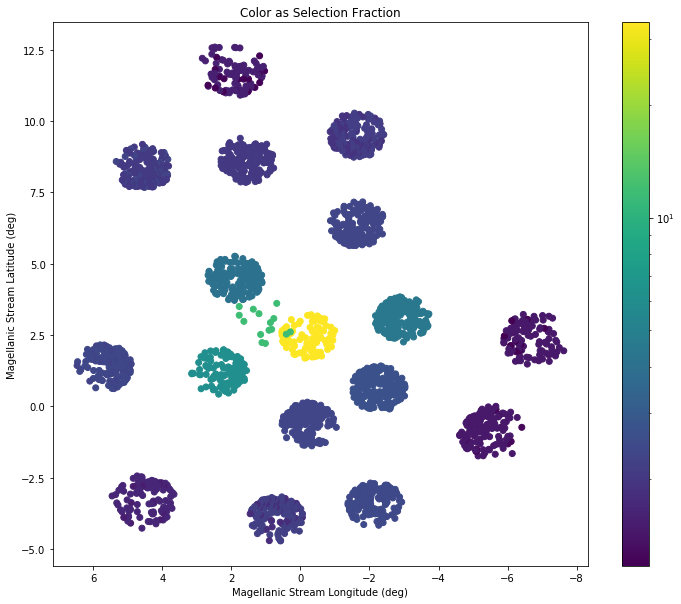

In [6]:
##########################
### Look at SELECTFUNC ###
##########################

'''SELECTFUNC is the ration of RGB to total stars observed'''

plt.figure(figsize=[12,10])
plt.scatter(ms_lg-360,ms_bg,c=clndr16['SELECTFUNC'],norm=matplotlib.colors.LogNorm())
plt.gca().invert_xaxis()
plt.title(r'Color as Selection Fraction')
plt.colorbar()
plt.xlabel(r'Magellanic Stream Longitude (deg)')
plt.ylabel(r'Magellanic Stream Latitude (deg)')
plt.savefig('selectionfunctionmap.pdf',bbox_inches='tight')
plt.show()

In [11]:
#######################
### Pick out Fields ###
#######################

dor30 = np.where(clndr16['FIELD']=='30Dor')
lmc1 = np.where(clndr16['FIELD']=='LMC1')
lmc2 = np.where(clndr16['FIELD']=='LMC2')
lmc3 = np.where(clndr16['FIELD']=='LMC3')
lmc4 = np.where(clndr16['FIELD']=='LMC4')
lmc5 = np.where(clndr16['FIELD']=='LMC5')
lmc6 = np.where(clndr16['FIELD']=='LMC6')
lmc7 = np.where(clndr16['FIELD']=='LMC7')
lmc8 = np.where(clndr16['FIELD']=='LMC8')
lmc9 = np.where(clndr16['FIELD']=='LMC9')
lmc10 = np.where(clndr16['FIELD']=='LMC10')
lmc11 = np.where(clndr16['FIELD']=='LMC11')
lmc12 = np.where(clndr16['FIELD']=='LMC12')
lmc13 = np.where(clndr16['FIELD']=='LMC13')
lmc14 = np.where(clndr16['FIELD']=='LMC14')
lmc16 = np.where(clndr16['FIELD']=='LMC16')
lmc17 = np.where(clndr16['FIELD']=='LMC17')

In [12]:
parsec

Zini,logAge,Mini,int_IMF,Mass,logL,logTe,logg,label,McoreTP,C_O,period0,period1,pmode,Mloss,tau1m,X,Y,Xc,Xn,Xo,Cexcess,Z,mbolmag,Jmag,Hmag,Ksmag
float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
3.9311e-05,8.0,4.6575217247,2.612146616,4.656,3.242,3.7073,1.646,3,0.0,0.537,0.0,0.0,-1,-1e-30,0.0,0.7505,0.249,8.875e-05,2.429e-05,0.0002204,-1.0,0.0005001,-3.334,-4.624,-5.081,-5.157
3.9311e-05,8.0,4.6576375961,2.6121473312,4.656,3.272,3.7016,1.592,3,0.0,0.533,0.0,0.0,-1,-1e-30,0.0,0.7504,0.2491,8.818e-05,2.447e-05,0.0002204,-1.0,0.0005,-3.411,-4.724,-5.194,-5.273
3.9311e-05,8.0,4.657687664,2.6121475697,4.656,3.293,3.6992,1.561,3,0.0,0.53,0.0,0.0,-1,-1e-30,0.0,0.7504,0.2491,8.753e-05,2.467e-05,0.0002204,-1.0,0.0005,-3.464,-4.786,-5.261,-5.342
3.9311e-05,8.0,4.6577339172,2.6121478081,4.656,3.311,3.6976,1.538,3,0.0,0.504,0.0,0.0,-1,-1e-30,0.0,0.7504,0.2491,8.334e-05,2.894e-05,0.0002204,-1.0,0.0005,-3.507,-4.836,-5.315,-5.397
3.9311e-05,8.0,4.6578030586,2.6121482849,4.657,3.337,3.6952,1.502,3,0.0,0.466,0.0,0.0,-1,-1e-30,0.0,0.7503,0.2492,7.704e-05,3.534e-05,0.0002204,-1.0,0.0005001,-3.573,-4.911,-5.396,-5.479
3.9311e-05,8.0,4.6578612328,2.6121487617,4.657,3.349,3.6943,1.486,3,0.0,0.447,0.0,0.0,-1,-1e-30,0.0,0.7503,0.2492,7.382e-05,3.933e-05,0.0002204,-1.0,0.0005004,-3.603,-4.945,-5.432,-5.515
3.9311e-05,8.0,4.6580653191,2.6121499538,4.657,3.38,3.6916,1.445,3,0.0,0.398,0.0,0.0,-1,-1e-30,0.0,0.7501,0.2494,6.569e-05,4.938e-05,0.0002203,-1.0,0.000502,-3.68,-5.033,-5.526,-5.611
3.9311e-05,8.0,4.6584000587,2.6121518612,4.657,3.401,3.6899,1.416,3,0.0,0.373,0.0,0.0,-1,-1e-30,0.0,0.75,0.2495,6.166e-05,5.437e-05,0.0002203,-1.0,0.0005014,-3.733,-5.093,-5.59,-5.676
3.9311e-05,8.0,4.659157753,2.6121566296,4.658,3.427,3.6879,1.383,3,0.0,0.347,0.0,0.0,-1,-1e-30,0.0,0.7498,0.2496,5.737e-05,5.968e-05,0.0002202,-1.0,0.00057,-3.798,-5.166,-5.667,-5.754


In [24]:
#############################################
### Mass of Fields with only Bright stars ###
#############################################

corabsH = absmag(clndr16['H'],stardist)-clndr16['AK_TARG']

'(age, met, maxAbs, minAbs, select, len(field))'

#bright fields: 30 Dor, 4, 5, 6, 8, 9, 13, 14

gen_age, gen_z = mc.findclosestparsec(7.22678482511063,-0.5,parsec)

#30 Dor
mass30dor = mc.fieldmass(gen_age,gen_z,np.max(corabsH[dor30]),np.min(corabsH[dor30]),
                         clndr16[dor30]['SELECTFUNC'][0],len(np.squeeze(dor30)),parsec)

#LMC 4
masslmc4 = mc.fieldmass(gen_age,gen_z,np.max(corabsH[lmc4]),np.min(corabsH[lmc4]),
                         clndr16[lmc4]['SELECTFUNC'][0],len(np.squeeze(lmc4)),parsec)

#LMC 5
masslmc5 = mc.fieldmass(gen_age,gen_z,np.max(corabsH[lmc5]),np.min(corabsH[lmc5]),
                         clndr16[lmc5]['SELECTFUNC'][0],len(np.squeeze(lmc5)),parsec)

#LMC 6
masslmc6 = mc.fieldmass(gen_age,gen_z,np.max(corabsH[lmc6]),np.min(corabsH[lmc6]),
                         clndr16[lmc6]['SELECTFUNC'][0],len(np.squeeze(lmc6)),parsec)

#LMC 8
masslmc8 = mc.fieldmass(gen_age,gen_z,np.max(corabsH[lmc8]),np.min(corabsH[lmc8]),
                         clndr16[lmc8]['SELECTFUNC'][0],len(np.squeeze(lmc8)),parsec)

#LMC 9
masslmc9 = mc.fieldmass(gen_age,gen_z,np.max(corabsH[lmc9]),np.min(corabsH[lmc9]),
                         clndr16[lmc9]['SELECTFUNC'][0],len(np.squeeze(lmc9)),parsec)

#LMC 13
masslmc13 = mc.fieldmass(gen_age,gen_z,np.max(corabsH[lmc13]),np.min(corabsH[lmc13]),
                         clndr16[lmc13]['SELECTFUNC'][0],len(np.squeeze(lmc13)),parsec)

#LMC 14
masslmc14 = mc.fieldmass(gen_age,gen_z,np.max(corabsH[lmc14]),np.min(corabsH[lmc14]),
                         clndr16[lmc14]['SELECTFUNC'][0],len(np.squeeze(lmc14)),parsec)


In [25]:
########################################################
### Mass of Fields with composite Bright/Faint stars ###
########################################################

fnt1 = np.where(clndr16[lmc1]['TARGET_NAME']=='FntRGB')
fnt2 = np.where(clndr16[lmc2]['TARGET_NAME']=='FntRGB')
fnt3 = np.where(clndr16[lmc3]['TARGET_NAME']=='FntRGB')
fnt7 = np.where(clndr16[lmc7]['TARGET_NAME']=='FntRGB')
fnt10 = np.where(clndr16[lmc10]['TARGET_NAME']=='FntRGB')
fnt11 = np.where(clndr16[lmc11]['TARGET_NAME']=='FntRGB')
fnt12 = np.where(clndr16[lmc12]['TARGET_NAME']=='FntRGB')
fnt16 = np.where(clndr16[lmc16]['TARGET_NAME']=='FntRGB')
fnt17 = np.where(clndr16[lmc17]['TARGET_NAME']=='FntRGB')

brt1 = np.where(clndr16[lmc1]['TARGET_NAME']=='BrtRGB')
brt2 = np.where(clndr16[lmc2]['TARGET_NAME']=='BrtRGB')
brt3 = np.where(clndr16[lmc3]['TARGET_NAME']=='BrtRGB')
brt7 = np.where(clndr16[lmc7]['TARGET_NAME']=='BrtRGB')
brt10 = np.where(clndr16[lmc10]['TARGET_NAME']=='BrtRGB')
brt11 = np.where(clndr16[lmc11]['TARGET_NAME']=='BrtRGB')
brt12 = np.where(clndr16[lmc12]['TARGET_NAME']=='BrtRGB')
brt16 = np.where(clndr16[lmc16]['TARGET_NAME']=='BrtRGB')
brt17 = np.where(clndr16[lmc17]['TARGET_NAME']=='BrtRGB')

gen_age, gen_z = mc.findclosestparsec(7.22678482511063,-0.5,parsec)

#LMC 1
fntlmc1 = mc.fieldmass(gen_age,gen_z,np.max(corabsH[lmc1][fnt1]),np.min(corabsH[lmc1][fnt1]),
                         clndr16[lmc1][fnt1]['SELECTFUNC'][0],len(np.squeeze(fnt1)),parsec)

brtlmc1 = mc.fieldmass(gen_age,gen_z,np.max(corabsH[lmc1][brt1]),np.min(corabsH[lmc1][brt1]),
                         clndr16[lmc1][brt1]['SELECTFUNC'][0],len(np.squeeze(brt1)),parsec)

masslmc1 = fntlmc1+brtlmc1

#LMC 2
fntlmc2 = mc.fieldmass(gen_age,gen_z,np.max(corabsH[lmc2][fnt2]),np.min(corabsH[lmc2][fnt2]),
                         clndr16[lmc2][fnt2]['SELECTFUNC'][0],len(np.squeeze(fnt2)),parsec)

brtlmc2 = mc.fieldmass(gen_age,gen_z,np.max(corabsH[lmc2][brt2]),np.min(corabsH[lmc2][brt2]),
                         clndr16[lmc2][brt2]['SELECTFUNC'][0],len(np.squeeze(brt2)),parsec)

masslmc2 = fntlmc2+brtlmc2

#LMC 3
fntlmc3 = mc.fieldmass(gen_age,gen_z,np.max(corabsH[lmc3][fnt3]),np.min(corabsH[lmc3][fnt3]),
                         clndr16[lmc3][fnt3]['SELECTFUNC'][0],len(np.squeeze(fnt3)),parsec)

brtlmc3 = mc.fieldmass(gen_age,gen_z,np.max(corabsH[lmc3][brt3]),np.min(corabsH[lmc3][brt3]),
                         clndr16[lmc3][brt3]['SELECTFUNC'][0],len(np.squeeze(brt3)),parsec)

masslmc3 = fntlmc3+brtlmc3

#LMC 7
fntlmc7 = mc.fieldmass(gen_age,gen_z,np.max(corabsH[lmc7][fnt7]),np.min(corabsH[lmc7][fnt7]),
                         clndr16[lmc7][fnt7]['SELECTFUNC'][0],len(np.squeeze(fnt7)),parsec)

brtlmc7 = mc.fieldmass(gen_age,gen_z,np.max(corabsH[lmc7][brt7]),np.min(corabsH[lmc7][brt7]),
                         clndr16[lmc7][brt7]['SELECTFUNC'][0],len(np.squeeze(brt7)),parsec)

masslmc7 = fntlmc7+brtlmc7

#LMC 10
fntlmc10 = mc.fieldmass(gen_age,gen_z,np.max(corabsH[lmc10][fnt10]),np.min(corabsH[lmc10][fnt10]),
                         clndr16[lmc10][fnt10]['SELECTFUNC'][0],len(np.squeeze(fnt10)),parsec)

brtlmc10 = mc.fieldmass(gen_age,gen_z,np.max(corabsH[lmc10][brt10]),np.min(corabsH[lmc10][brt10]),
                         clndr16[lmc10][brt10]['SELECTFUNC'][0],len(np.squeeze(brt10)),parsec)

masslmc10 = fntlmc10+brtlmc10

#LMC 11
fntlmc11 = mc.fieldmass(gen_age,gen_z,np.max(corabsH[lmc11][fnt11]),np.min(corabsH[lmc11][fnt11]),
                         clndr16[lmc11][fnt11]['SELECTFUNC'][0],len(np.squeeze(fnt11)),parsec)

brtlmc11 = mc.fieldmass(gen_age,gen_z,np.max(corabsH[lmc11][brt11]),np.min(corabsH[lmc11][brt11]),
                         clndr16[lmc11][brt11]['SELECTFUNC'][0],len(np.squeeze(brt11)),parsec)

masslmc11 = fntlmc11+brtlmc11

#LMC 12
fntlmc12 = mc.fieldmass(gen_age,gen_z,np.max(corabsH[lmc12][fnt12]),np.min(corabsH[lmc12][fnt12]),
                         clndr16[lmc12][fnt12]['SELECTFUNC'][0],len(np.squeeze(fnt12)),parsec)

brtlmc12 = mc.fieldmass(gen_age,gen_z,np.max(corabsH[lmc12][brt12]),np.min(corabsH[lmc12][brt12]),
                         clndr16[lmc12][brt12]['SELECTFUNC'][0],len(np.squeeze(brt12)),parsec)

masslmc12 = fntlmc12+brtlmc12

#LMC 16
fntlmc16 = mc.fieldmass(gen_age,gen_z,np.max(corabsH[lmc16][fnt16]),np.min(corabsH[lmc16][fnt16]),
                         clndr16[lmc16][fnt16]['SELECTFUNC'][0],len(np.squeeze(fnt16)),parsec)

brtlmc16 = mc.fieldmass(gen_age,gen_z,np.max(corabsH[lmc16][brt16]),np.min(corabsH[lmc16][brt16]),
                         clndr16[lmc16][brt16]['SELECTFUNC'][0],len(np.squeeze(brt16)),parsec)

masslmc16 = fntlmc16+brtlmc16

#LMC 17
fntlmc17 = mc.fieldmass(gen_age,gen_z,np.max(corabsH[lmc17][fnt17]),np.min(corabsH[lmc17][fnt17]),
                         clndr16[lmc17][fnt17]['SELECTFUNC'][0],len(np.squeeze(fnt17)),parsec)

brtlmc17 = mc.fieldmass(gen_age,gen_z,np.max(corabsH[lmc17][brt17]),np.min(corabsH[lmc17][brt17]),
                         clndr16[lmc17][brt17]['SELECTFUNC'][0],len(np.squeeze(brt17)),parsec)

masslmc17 = fntlmc17+brtlmc17

In [26]:
#######################################
### All Field Masses and Total Mass ###
#######################################

print('30 Dor: '+str(mass30dor)+' Msol')
print('LMC 1: '+str(masslmc1)+' Msol')
print('LMC 2: '+str(masslmc2)+' Msol')
print('LMC 3: '+str(masslmc3)+' Msol')
print('LMC 4: '+str(masslmc4)+' Msol')
print('LMC 5: '+str(masslmc5)+' Msol')
print('LMC 6: '+str(masslmc6)+' Msol')
print('LMC 7: '+str(masslmc7)+' Msol')
print('LMC 8: '+str(masslmc8)+' Msol')
print('LMC 9: '+str(masslmc9)+' Msol')
print('LMC 10: '+str(masslmc10)+' Msol')
print('LMC 11: '+str(masslmc11)+' Msol')
print('LMC 12: '+str(masslmc12)+' Msol')
print('LMC 13: '+str(masslmc13)+' Msol')
print('LMC 14: '+str(masslmc14)+' Msol')
print('LMC 16: '+str(masslmc16)+' Msol')
print('LMC 17: '+str(masslmc17)+' Msol')
print('LMC RGB total: '+str((mass30dor+masslmc1+masslmc3+masslmc4+masslmc5+masslmc6+masslmc7+masslmc8+masslmc9+
                      masslmc10+masslmc11+masslmc12+masslmc13+masslmc14+masslmc16+masslmc17)/(10**9))+' GMsol')

30 Dor: 27621106.91200853 Msol
LMC 1: 4669445.047542936 Msol
LMC 2: 5446368.23676144 Msol
LMC 3: 21202180.017408393 Msol
LMC 4: 56596524.02206324 Msol
LMC 5: 53360677.129775755 Msol
LMC 6: 39668735.2726289 Msol
LMC 7: 24467551.18096613 Msol
LMC 8: 46957585.46629441 Msol
LMC 9: 258437043.18683618 Msol
LMC 10: 15484584.075289834 Msol
LMC 11: 53119526.19802793 Msol
LMC 12: 3907378.6679609683 Msol
LMC 13: 56376369.26340361 Msol
LMC 14: 67310899.91201074 Msol
LMC 16: 4530904.187024217 Msol
LMC 17: 23769777.531377986 Msol
LMC RGB total: 0.75748028807062 GMsol


In [198]:
mass = [mass30dor,masslmc1,masslmc2,masslmc3,masslmc4,masslmc5,masslmc6,masslmc7,masslmc8,masslmc9,
                      masslmc10,masslmc11,masslmc12,masslmc13,masslmc14,masslmc16,masslmc17]

masses = []
for i in range(len(clndr16)):
    if clndr16['FIELD'][i] == '30Dor':
        masses.append(mass30dor)
    if clndr16['FIELD'][i] == 'LMC1':
        masses.append(masslmc1)
    if clndr16['FIELD'][i] == 'LMC2':
        masses.append(masslmc2)
    if clndr16['FIELD'][i] == 'LMC3':
        masses.append(masslmc3)
    if clndr16['FIELD'][i] == 'LMC4':
        masses.append(masslmc4)
    if clndr16['FIELD'][i] == 'LMC5':
        masses.append(masslmc5)
    if clndr16['FIELD'][i] == 'LMC6':
        masses.append(masslmc6)
    if clndr16['FIELD'][i] == 'LMC7':
        masses.append(masslmc7)
    if clndr16['FIELD'][i] == 'LMC8':
        masses.append(masslmc8)
    if clndr16['FIELD'][i] == 'LMC9':
        masses.append(masslmc9)
    if clndr16['FIELD'][i] == 'LMC10':
        masses.append(masslmc10)
    if clndr16['FIELD'][i] == 'LMC11':
        masses.append(masslmc11)
    if clndr16['FIELD'][i] == 'LMC12':
        masses.append(masslmc12)
    if clndr16['FIELD'][i] == 'LMC13':
        masses.append(masslmc13)
    if clndr16['FIELD'][i] == 'LMC14':
        masses.append(masslmc14)
    if clndr16['FIELD'][i] == 'LMC15':
        masses.append(masslmc15)
    if clndr16['FIELD'][i] == 'LMC16':
        masses.append(masslmc16)
    if clndr16['FIELD'][i] == 'LMC17':
        masses.append(masslmc17)

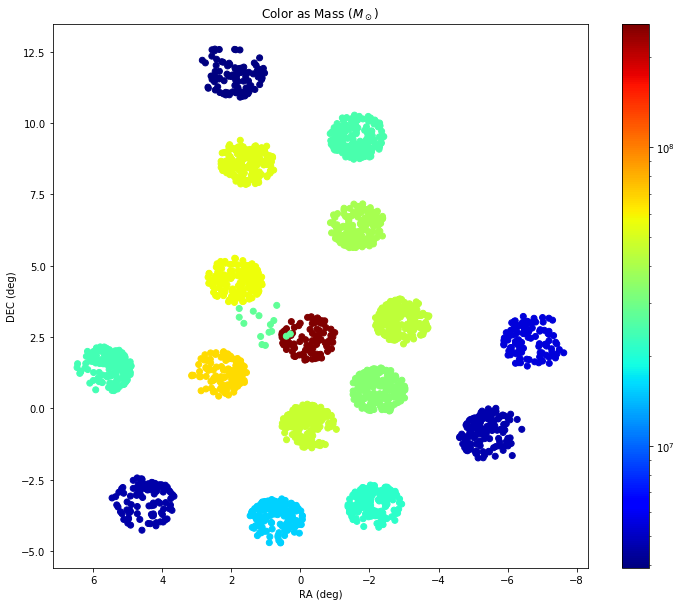

In [199]:
plt.figure(figsize=[12,10])
plt.scatter(ms_lg-360,ms_bg,c=masses,cmap='jet',norm=matplotlib.colors.LogNorm())
plt.gca().invert_xaxis()
plt.title(r'Color as Mass ($M_\odot$)')
plt.colorbar()
plt.xlabel(r'RA (deg)')
plt.ylabel(r'DEC (deg)')
plt.savefig('massmap.pdf',bbox_inches='tight')
plt.show()

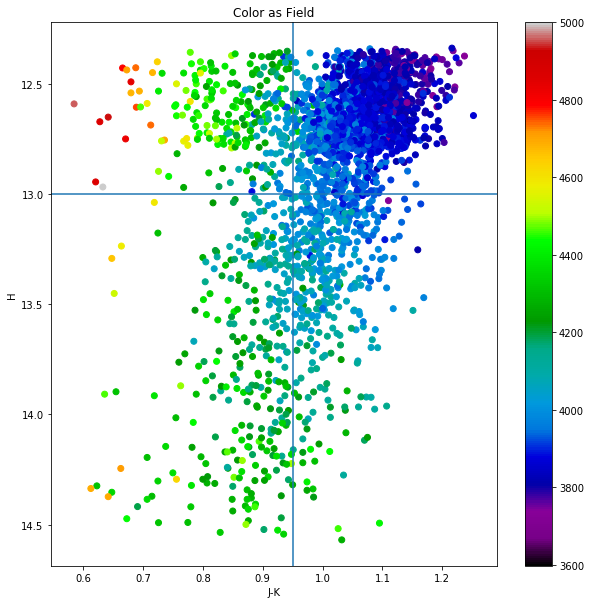

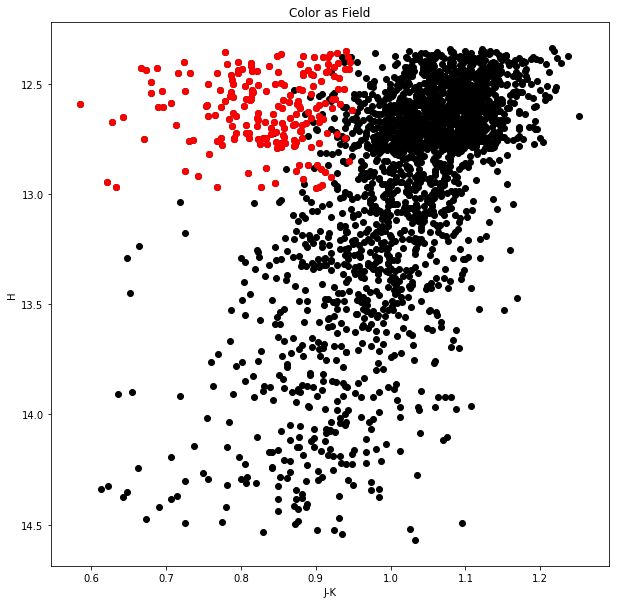

In [29]:
############################
### Find Blue Loop Stars ###
############################

###HR Diagram to find blue loop stars
plt.figure(figsize=[10,10])
plt.scatter((clndr16['J']-clndr16['K']),clndr16['H'],c=clndr16['TEFF'],cmap='nipy_spectral')
plt.axhline(13)
plt.axvline(0.95)
plt.gca().invert_yaxis()
plt.xlabel('J-K')
plt.title(r'Color as Field')
plt.ylabel('H')
plt.colorbar()
plt.show()

###Remove blue loop stars in data
bloop = np.where((clndr16['TEFF']>=4100)&(clndr16['H']<=13.0)&((clndr16['J']-clndr16['K'])<=0.95))

plt.figure(figsize=[10,10])
plt.scatter((clndr16['J']-clndr16['K']),clndr16['H'],color='k')
plt.scatter((clndr16['J']-clndr16['K'])[bloop],clndr16['H'][bloop],color='r')
# plt.axhline(13)
plt.gca().invert_yaxis()
plt.xlabel('J-K')
plt.title(r'Color as Field')
plt.ylabel('H')
plt.show()

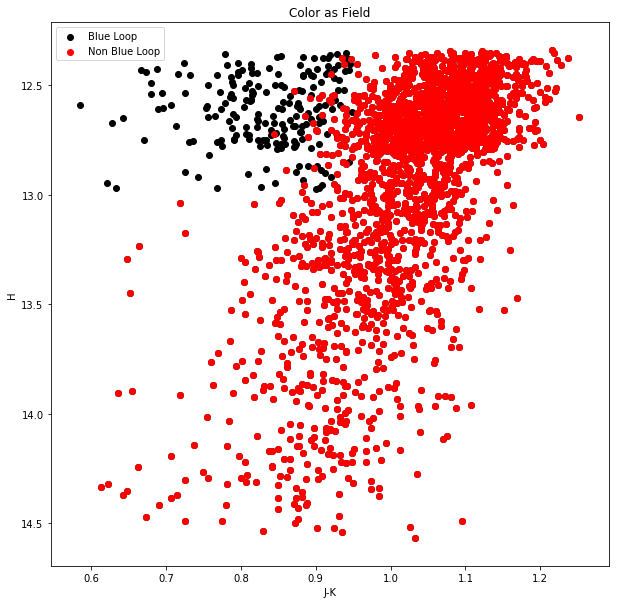

In [30]:
bloop_cut = []
for i in range(len(clndr16)):
    if i not in np.squeeze(bloop).tolist():
        bloop_cut.append(i)

r13bloop_cut = clndr16[bloop_cut]
# print(np.squeeze(bloop).tolist())
# print(bloop_cut)

plt.figure(figsize=[10,10])
plt.scatter((clndr16['J']-clndr16['K']),clndr16['H'],color='k',label='Blue Loop')
plt.scatter((r13bloop_cut['J']-r13bloop_cut['K']),r13bloop_cut['H'],color='r',label='Non Blue Loop')
# plt.axhline(13)
plt.gca().invert_yaxis()
plt.xlabel('J-K')
plt.title(r'Color as Field')
plt.ylabel('H')
plt.legend()
plt.show()

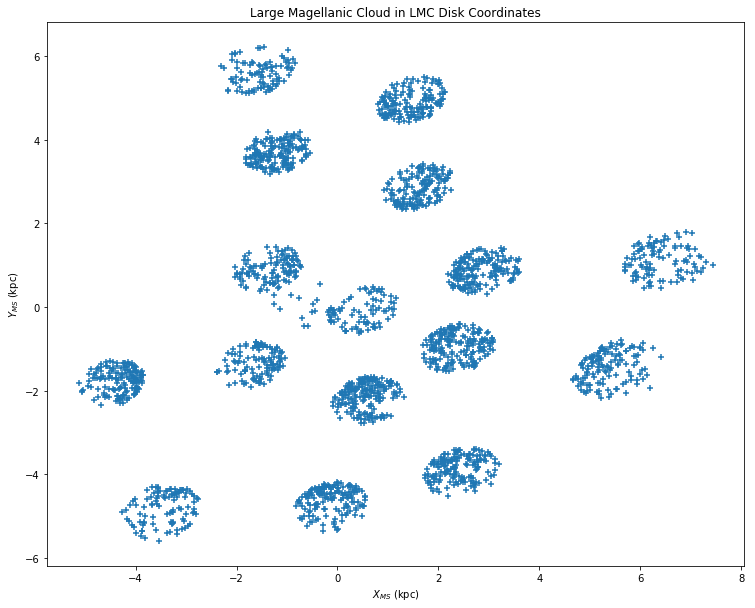

In [31]:
#####################################
### Plot in Cartesian Coordinates ###
#####################################

'''Double check units'''

#No Blue Loop Stars

x_m, y_m, dis = LMCdisk_cart(clndr16['RA'][bloop_cut],clndr16['DEC'][bloop_cut])
# color = np.degrees(np.arctan2(y_m,x_m)-(np.pi/2)*np.ones(len(np.arctan2(y_m,x_m))))
# for i in range(len(color)):
#     if color[i]<0:
#         color[i] = color[i]+360

plt.figure(figsize=[12.5,10])
plt.scatter(x_m,y_m, marker='+')
plt.xlabel(r'$X_{MS}$ (kpc)')
plt.ylabel(r'$Y_{MS}$ (kpc)')
plt.title(r'Large Magellanic Cloud in LMC Disk Coordinates')
# plt.colorbar()
plt.savefig('LMCxy.jpg',bbox_inches='tight')
plt.show()

(array([450., 260., 163., 172., 141., 117., 117., 100.,  91.,  91.]),
 array([ 0. ,  1.4,  2.8,  4.2,  5.6,  7. ,  8.4,  9.8, 11.2, 12.6, 14. ]),
 <a list of 10 Patch objects>)

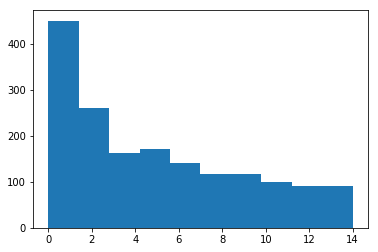

In [32]:
plt.hist((10**parage)/10**9,range=(0,14))

In [33]:
########################
### Area Calculation ###
########################

area30dor = ac.apogee_field_area('30Dor',r13bloop_cut)
arealmc1 = ac.apogee_field_area('LMC1',r13bloop_cut)
arealmc2 = ac.apogee_field_area('LMC2',r13bloop_cut)
arealmc3 = ac.apogee_field_area('LMC3',r13bloop_cut)
arealmc4 = ac.apogee_field_area('LMC4',r13bloop_cut)
arealmc5 = ac.apogee_field_area('LMC5',r13bloop_cut)
arealmc6 = ac.apogee_field_area('LMC6',r13bloop_cut)
arealmc7 = ac.apogee_field_area('LMC7',r13bloop_cut)
arealmc8 = ac.apogee_field_area('LMC8',r13bloop_cut)
arealmc9 = ac.apogee_field_area('LMC9',r13bloop_cut)
arealmc10 = ac.apogee_field_area('LMC10',r13bloop_cut)
arealmc11 = ac.apogee_field_area('LMC11',r13bloop_cut)
arealmc12 = ac.apogee_field_area('LMC12',r13bloop_cut)
arealmc13 = ac.apogee_field_area('LMC13',r13bloop_cut)
arealmc14 = ac.apogee_field_area('LMC14',r13bloop_cut)
arealmc16 = ac.apogee_field_area('LMC16',r13bloop_cut)
arealmc17 = ac.apogee_field_area('LMC17',r13bloop_cut)

areas = [area30dor,arealmc1,arealmc2,arealmc3,arealmc4,arealmc5,arealmc6,arealmc7,arealmc8,arealmc9,arealmc10,
         arealmc11,arealmc12,arealmc13,arealmc14,arealmc16,arealmc17]


                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                   17
Model:                            RLM   Df Residuals:                       15
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 05 Mar 2020                                         
Time:                        11:11:28                                         
No. Iterations:                    13                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.6689      0.081     70.273      0.0

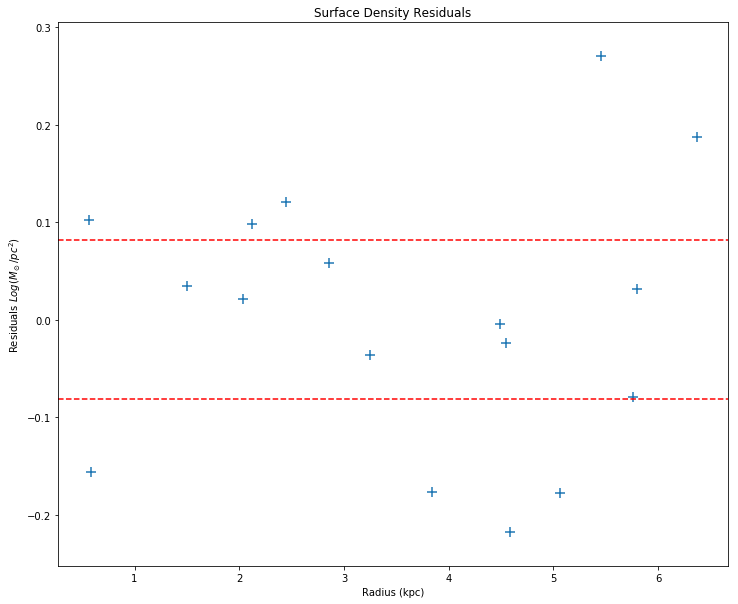

mad(Residual): 0.08154824692912843


In [193]:
'''
model is sigma = A*exp(B*r)
A central density 
B radial scale height 
r radius

ln(sigma) = lnA + B*r
'''

import statsmodels.api as sm 

bdor30 = np.where(r13bloop_cut['Field']=='30Dor')
blmc1 = np.where(r13bloop_cut['Field']=='LMC1')
blmc2 = np.where(r13bloop_cut['Field']=='LMC2')
blmc3 = np.where(r13bloop_cut['Field']=='LMC3')
blmc4 = np.where(r13bloop_cut['Field']=='LMC4')
blmc5 = np.where(r13bloop_cut['Field']=='LMC5')
blmc6 = np.where(r13bloop_cut['Field']=='LMC6')
blmc7 = np.where(r13bloop_cut['Field']=='LMC7')
blmc8 = np.where(r13bloop_cut['Field']=='LMC8')
blmc9 = np.where(r13bloop_cut['Field']=='LMC9')
blmc10 = np.where(r13bloop_cut['Field']=='LMC10')
blmc11 = np.where(r13bloop_cut['Field']=='LMC11')
blmc12 = np.where(r13bloop_cut['Field']=='LMC12')
blmc13 = np.where(r13bloop_cut['Field']=='LMC13')
blmc14 = np.where(r13bloop_cut['Field']=='LMC14')
blmc16 = np.where(r13bloop_cut['Field']=='LMC16')
blmc17 = np.where(r13bloop_cut['Field']=='LMC17')

fields = [bdor30,blmc1,blmc2,blmc3,blmc4,blmc5,blmc6,blmc7,blmc8,blmc9,blmc10,blmc11,blmc12,blmc13,blmc14,blmc16
          ,blmc17]

radii = []
angles = []
surfden = []
for i in range(len(fields)):
    radii.append(np.sqrt(np.median(LMCdisk_cart(r13bloop_cut['RA'][fields[i]],
                                                r13bloop_cut['DEC'][fields[i]])[0])**2+
                         np.median(LMCdisk_cart(r13bloop_cut['RA'][fields[i]],
                                                r13bloop_cut['DEC'][fields[i]])[1])**2))
    
    surfden.append((masses[i]/areas[i]))

model = np.array([radii]).T
model = sm.add_constant(model)
model_model = sm.RLM(np.log(np.divide(surfden,10**6)),model).fit()
model_predictions = model_model.predict(model)
model_residual = model_predictions - np.log(np.divide(surfden,10**6))
model_summary = model_model.summary()
print(model_summary)
print(np.asarray(model_model.params))
plt.figure(figsize=[12,10])
plt.scatter(radii,model_residual,marker='+',label='Residuals',cmap='nipy_spectral',s=100)
plt.axhline(mad(model_residual),linestyle='--',c='r',label='MAD')
plt.axhline(-mad(model_residual),linestyle='--',c='r')
plt.title(r'Surface Density Residuals')
plt.xlabel(r'Radius (kpc)')
plt.ylabel(r'Residuals $Log(M_\odot/pc^2)$')
# plt.colorbar()
# plt.savefig('residexpmodel.pdf',bbox_inches='tight')
plt.show()
print('mad(Residual):',mad(model_residual))

In [34]:
np.reciprocal(0.06985609)

14.315144177121853

In [35]:
dense = []
for i in range(len(clndr16)):
    if clndr16['FIELD'][i] == '30Dor':
        dense.append(surfden[0])
    if clndr16['FIELD'][i] == 'LMC1':
        dense.append(surfden[1])
    if clndr16['FIELD'][i] == 'LMC2':
        dense.append(surfden[2])
    if clndr16['FIELD'][i] == 'LMC3':
        dense.append(surfden[3])
    if clndr16['FIELD'][i] == 'LMC4':
        dense.append(surfden[4])
    if clndr16['FIELD'][i] == 'LMC5':
        dense.append(surfden[5])
    if clndr16['FIELD'][i] == 'LMC6':
        dense.append(surfden[6])
    if clndr16['FIELD'][i] == 'LMC7':
        dense.append(surfden[7])
    if clndr16['FIELD'][i] == 'LMC8':
        dense.append(surfden[8])
    if clndr16['FIELD'][i] == 'LMC9':
        dense.append(surfden[9])
    if clndr16['FIELD'][i] == 'LMC10':
        dense.append(surfden[10])
    if clndr16['FIELD'][i] == 'LMC11':
        dense.append(surfden[11])
    if clndr16['FIELD'][i] == 'LMC12':
        dense.append(surfden[12])
    if clndr16['FIELD'][i] == 'LMC13':
        dense.append(surfden[13])
    if clndr16['FIELD'][i] == 'LMC14':
        dense.append(surfden[14])
    if clndr16['FIELD'][i] == 'LMC16':
        dense.append(surfden[15])
    if clndr16['FIELD'][i] == 'LMC17':
        dense.append(surfden[16])

In [207]:
areas

[0.7946870787176962,
 1.711156159216112,
 1.6788772911045944,
 1.2155268489625297,
 1.1548191887577446,
 1.19461632006079,
 1.0790651925549228,
 1.0630613547682033,
 1.1415344184222538,
 1.0284605532994844,
 1.196636066560338,
 0.9778110787367342,
 1.2322549533559548,
 1.0250967432221438,
 1.0503453609800613,
 1.380437802696846,
 0.9877936602287144]

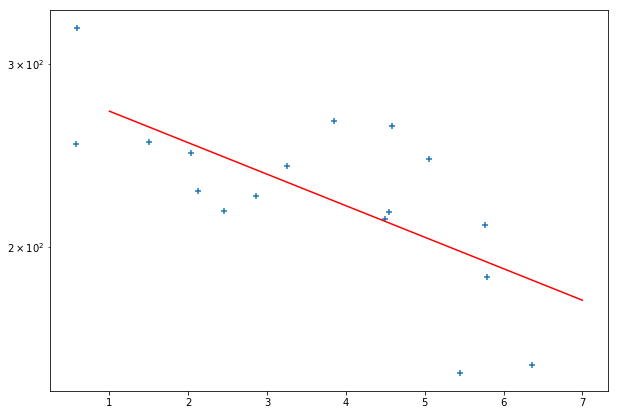

In [218]:
plt.figure(figsize=[10,7])
plt.scatter(radii,np.divide(surfden,10**6),marker="+")
plt.plot([1,2,3,4,5,6,7],np.exp(5.66893154)*np.exp(np.multiply(-0.06985609,[1,2,3,4,5,6,7])),c='r')
plt.yscale('log')


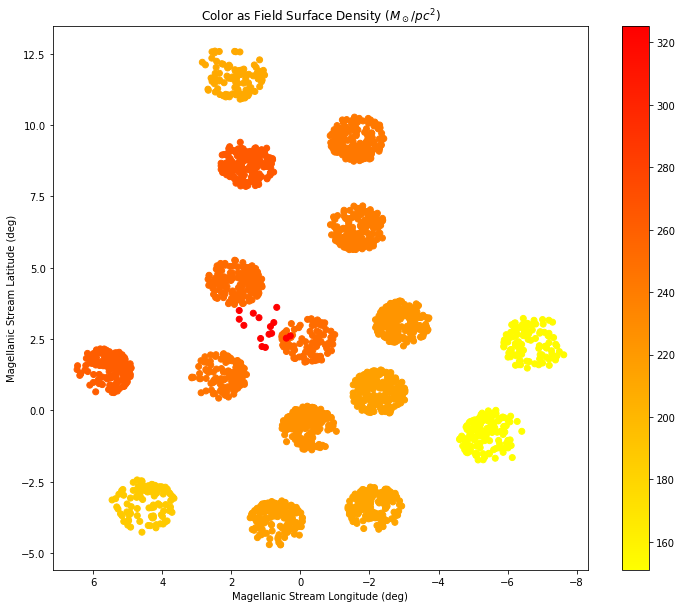

In [36]:
plt.figure(figsize=[12,10])
plt.scatter(ms_lg-360,ms_bg,c=np.divide(dense,10**6),cmap='autumn_r')
plt.gca().invert_xaxis()
plt.title(r'Color as Field Surface Density ($M_\odot/pc^2$)')
plt.colorbar()
plt.xlabel(r'Magellanic Stream Longitude (deg)')
plt.ylabel(r'Magellanic Stream Latitude (deg)')
plt.savefig('densemap.pdf',bbox_inches='tight')
plt.show()

$\Huge{AGE}\,$ $\, \Huge{BINS}$

In [37]:
young = np.where(parage<=np.log10(3.5*10**9))
ymed = np.where((parage>np.log10(3.5*10**9))&(parage<=np.log10(7*10**9)))
omed = np.where((parage>np.log10(7*10**9))&(parage<=np.log10(10.5*10**9)))
old = np.where(parage>np.log10(10.5*10**9))

In [38]:
# ### young 
# young_dor30 = np.where((clndr16['FIELD'][young]=='30Dor'))
# young_lmc1 = np.where((clndr16['FIELD'][young]=='LMC1'))
# young_lmc2 = np.where((clndr16['FIELD'][young]=='LMC2'))
# young_lmc3 = np.where((clndr16['FIELD'][young]=='LMC3'))
# young_lmc4 = np.where((clndr16['FIELD'][young]=='LMC4'))
# young_lmc5 = np.where((clndr16['FIELD'][young]=='LMC5'))
# young_lmc6 = np.where((clndr16['FIELD'][young]=='LMC6'))
# young_lmc7 = np.where((clndr16['FIELD'][young]=='LMC7'))
# young_lmc8 = np.where((clndr16['FIELD'][young]=='LMC8'))
# young_lmc9 = np.where((clndr16['FIELD'][young]=='LMC9'))
# young_lmc10 = np.where((clndr16['FIELD'][young]=='LMC10'))
# young_lmc11 = np.where((clndr16['FIELD'][young]=='LMC11'))
# young_lmc12 = np.where((clndr16['FIELD'][young]=='LMC12'))
# young_lmc13 = np.where((clndr16['FIELD'][young]=='LMC13'))
# young_lmc14 = np.where((clndr16['FIELD'][young]=='LMC14'))
# young_lmc16 = np.where((clndr16['FIELD'][young]=='LMC16'))
# young_lmc17 = np.where((clndr16['FIELD'][young]=='LMC17'))

# ### ymed 
# ymed_dor30 = np.where((clndr16['FIELD'][ymed]=='30Dor'))
# ymed_lmc1 = np.where((clndr16['FIELD'][ymed]=='LMC1'))
# ymed_lmc2 = np.where((clndr16['FIELD'][ymed]=='LMC2'))
# ymed_lmc3 = np.where((clndr16['FIELD'][ymed]=='LMC3'))
# ymed_lmc4 = np.where((clndr16['FIELD'][ymed]=='LMC4'))
# ymed_lmc5 = np.where((clndr16['FIELD'][ymed]=='LMC5'))
# ymed_lmc6 = np.where((clndr16['FIELD'][ymed]=='LMC6'))
# ymed_lmc7 = np.where((clndr16['FIELD'][ymed]=='LMC7'))
# ymed_lmc8 = np.where((clndr16['FIELD'][ymed]=='LMC8'))
# ymed_lmc9 = np.where((clndr16['FIELD'][ymed]=='LMC9'))
# ymed_lmc10 = np.where((clndr16['FIELD'][ymed]=='LMC10'))
# ymed_lmc11 = np.where((clndr16['FIELD'][ymed]=='LMC11'))
# ymed_lmc12 = np.where((clndr16['FIELD'][ymed]=='LMC12'))
# ymed_lmc13 = np.where((clndr16['FIELD'][ymed]=='LMC13'))
# ymed_lmc14 = np.where((clndr16['FIELD'][ymed]=='LMC14'))
# ymed_lmc16 = np.where((clndr16['FIELD'][ymed]=='LMC16'))
# ymed_lmc17 = np.where((clndr16['FIELD'][ymed]=='LMC17'))

# ### omed 
# omed_dor30 = np.where((clndr16['FIELD'][omed]=='30Dor'))
# omed_lmc1 = np.where((clndr16['FIELD'][omed]=='LMC1'))
# omed_lmc2 = np.where((clndr16['FIELD'][omed]=='LMC2'))
# omed_lmc3 = np.where((clndr16['FIELD'][omed]=='LMC3'))
# omed_lmc4 = np.where((clndr16['FIELD'][omed]=='LMC4'))
# omed_lmc5 = np.where((clndr16['FIELD'][omed]=='LMC5'))
# omed_lmc6 = np.where((clndr16['FIELD'][omed]=='LMC6'))
# omed_lmc7 = np.where((clndr16['FIELD'][omed]=='LMC7'))
# omed_lmc8 = np.where((clndr16['FIELD'][omed]=='LMC8'))
# omed_lmc9 = np.where((clndr16['FIELD'][omed]=='LMC9'))
# omed_lmc10 = np.where((clndr16['FIELD'][omed]=='LMC10'))
# omed_lmc11 = np.where((clndr16['FIELD'][omed]=='LMC11'))
# omed_lmc12 = np.where((clndr16['FIELD'][omed]=='LMC12'))
# omed_lmc13 = np.where((clndr16['FIELD'][omed]=='LMC13'))
# omed_lmc14 = np.where((clndr16['FIELD'][omed]=='LMC14'))
# omed_lmc16 = np.where((clndr16['FIELD'][omed]=='LMC16'))
# omed_lmc17 = np.where((clndr16['FIELD'][omed]=='LMC17'))

# ### old 
# old_dor30 = np.where((clndr16['FIELD'][old]=='30Dor'))
# old_lmc1 = np.where((clndr16['FIELD'][old]=='LMC1'))
# old_lmc2 = np.where((clndr16['FIELD'][old]=='LMC2'))
# old_lmc3 = np.where((clndr16['FIELD'][old]=='LMC3'))
# old_lmc4 = np.where((clndr16['FIELD'][old]=='LMC4'))
# old_lmc5 = np.where((clndr16['FIELD'][old]=='LMC5'))
# old_lmc6 = np.where((clndr16['FIELD'][old]=='LMC6'))
# old_lmc7 = np.where((clndr16['FIELD'][old]=='LMC7'))
# old_lmc8 = np.where((clndr16['FIELD'][old]=='LMC8'))
# old_lmc9 = np.where((clndr16['FIELD'][old]=='LMC9'))
# old_lmc10 = np.where((clndr16['FIELD'][old]=='LMC10'))
# old_lmc11 = np.where((clndr16['FIELD'][old]=='LMC11'))
# old_lmc12 = np.where((clndr16['FIELD'][old]=='LMC12'))
# old_lmc13 = np.where((clndr16['FIELD'][old]=='LMC13'))
# old_lmc14 = np.where((clndr16['FIELD'][old]=='LMC14'))
# old_lmc16 = np.where((clndr16['FIELD'][old]=='LMC16'))
# old_lmc17 = np.where((clndr16['FIELD'][old]=='LMC17'))

In [39]:
# print(ymed_lmc17)

In [40]:
# #######################
# ### Pick out Fields ###
# #######################

# ### young 
young_dor30 = np.where((clndr16['FIELD']=='30Dor')&(parage<=np.log10(3.5*10**9)))
young_lmc1 = np.where((clndr16['FIELD']=='LMC1')&(parage<=np.log10(3.5*10**9)))
young_lmc2 = np.where((clndr16['FIELD']=='LMC2')&(parage<=np.log10(3.5*10**9)))
young_lmc3 = np.where((clndr16['FIELD']=='LMC3')&(parage<=np.log10(3.5*10**9)))
young_lmc4 = np.where((clndr16['FIELD']=='LMC4')&(parage<=np.log10(3.5*10**9)))
young_lmc5 = np.where((clndr16['FIELD']=='LMC5')&(parage<=np.log10(3.5*10**9)))
young_lmc6 = np.where((clndr16['FIELD']=='LMC6')&(parage<=np.log10(3.5*10**9)))
young_lmc7 = np.where((clndr16['FIELD']=='LMC7')&(parage<=np.log10(3.5*10**9)))
young_lmc8 = np.where((clndr16['FIELD']=='LMC8')&(parage<=np.log10(3.5*10**9)))
young_lmc9 = np.where((clndr16['FIELD']=='LMC9')&(parage<=np.log10(3.5*10**9)))
young_lmc10 = np.where((clndr16['FIELD']=='LMC10')&(parage<=np.log10(3.5*10**9)))
young_lmc11 = np.where((clndr16['FIELD']=='LMC11')&(parage<=np.log10(3.5*10**9)))
young_lmc12 = np.where((clndr16['FIELD']=='LMC12')&(parage<=np.log10(3.5*10**9)))
young_lmc13 = np.where((clndr16['FIELD']=='LMC13')&(parage<=np.log10(3.5*10**9)))
young_lmc14 = np.where((clndr16['FIELD']=='LMC14')&(parage<=np.log10(3.5*10**9)))
young_lmc16 = np.where((clndr16['FIELD']=='LMC16')&(parage<=np.log10(3.5*10**9)))
young_lmc17 = np.where((clndr16['FIELD']=='LMC17')&(parage<=np.log10(3.5*10**9)))

### ymed
ymed_dor30 = np.where((clndr16['FIELD']=='30Dor')&(parage>np.log10(3.5*10**9))&(parage<=np.log10(7*10**9)))
ymed_lmc1 = np.where((clndr16['FIELD']=='LMC1')&(parage>np.log10(3.5*10**9))&(parage<=np.log10(7*10**9)))
ymed_lmc2 = np.where((clndr16['FIELD']=='LMC2')&(parage>np.log10(3.5*10**9))&(parage<=np.log10(7*10**9)))
ymed_lmc3 = np.where((clndr16['FIELD']=='LMC3')&(parage>np.log10(3.5*10**9))&(parage<=np.log10(7*10**9)))
ymed_lmc4 = np.where((clndr16['FIELD']=='LMC4')&(parage>np.log10(3.5*10**9))&(parage<=np.log10(7*10**9)))
ymed_lmc5 = np.where((clndr16['FIELD']=='LMC5')&(parage>np.log10(3.5*10**9))&(parage<=np.log10(7*10**9)))
ymed_lmc6 = np.where((clndr16['FIELD']=='LMC6')&(parage>np.log10(3.5*10**9))&(parage<=np.log10(7*10**9)))
ymed_lmc7 = np.where((clndr16['FIELD']=='LMC7')&(parage>np.log10(3.5*10**9))&(parage<=np.log10(7*10**9)))
ymed_lmc8 = np.where((clndr16['FIELD']=='LMC8')&(parage>np.log10(3.5*10**9))&(parage<=np.log10(7*10**9)))
ymed_lmc9 = np.where((clndr16['FIELD']=='LMC9')&(parage>np.log10(3.5*10**9))&(parage<=np.log10(7*10**9)))
ymed_lmc10 = np.where((clndr16['FIELD']=='LMC10')&(parage>np.log10(3.5*10**9))&(parage<=np.log10(7*10**9)))
ymed_lmc11 = np.where((clndr16['FIELD']=='LMC11')&(parage>np.log10(3.5*10**9))&(parage<=np.log10(7*10**9)))
ymed_lmc12 = np.where((clndr16['FIELD']=='LMC12')&(parage>np.log10(3.5*10**9))&(parage<=np.log10(7*10**9)))
ymed_lmc13 = np.where((clndr16['FIELD']=='LMC13')&(parage>np.log10(3.5*10**9))&(parage<=np.log10(7*10**9)))
ymed_lmc14 = np.where((clndr16['FIELD']=='LMC14')&(parage>np.log10(3.5*10**9))&(parage<=np.log10(7*10**9)))
ymed_lmc16 = np.where((clndr16['FIELD']=='LMC16')&(parage>np.log10(3.5*10**9))&(parage<=np.log10(7*10**9)))
ymed_lmc17 = np.where((clndr16['FIELD']=='LMC17')&(parage>np.log10(3.5*10**9))&(parage<=np.log10(7*10**9)))

### omed
omed_dor30 = np.where((clndr16['FIELD']=='30Dor')&(parage>np.log10(7*10**9))&(parage<=np.log10(10.5*10**9)))
omed_lmc1 = np.where((clndr16['FIELD']=='LMC1')&(parage>np.log10(7*10**9))&(parage<=np.log10(10.5*10**9)))
omed_lmc2 = np.where((clndr16['FIELD']=='LMC2')&(parage>np.log10(7*10**9))&(parage<=np.log10(10.5*10**9)))
omed_lmc3 = np.where((clndr16['FIELD']=='LMC3')&(parage>np.log10(7*10**9))&(parage<=np.log10(10.5*10**9)))
omed_lmc4 = np.where((clndr16['FIELD']=='LMC4')&(parage>np.log10(7*10**9))&(parage<=np.log10(10.5*10**9)))
omed_lmc5 = np.where((clndr16['FIELD']=='LMC5')&(parage>np.log10(7*10**9))&(parage<=np.log10(10.5*10**9)))
omed_lmc6 = np.where((clndr16['FIELD']=='LMC6')&(parage>np.log10(7*10**9))&(parage<=np.log10(10.5*10**9)))
omed_lmc7 = np.where((clndr16['FIELD']=='LMC7')&(parage>np.log10(7*10**9))&(parage<=np.log10(10.5*10**9)))
omed_lmc8 = np.where((clndr16['FIELD']=='LMC8')&(parage>np.log10(7*10**9))&(parage<=np.log10(10.5*10**9)))
omed_lmc9 = np.where((clndr16['FIELD']=='LMC9')&(parage>np.log10(7*10**9))&(parage<=np.log10(10.5*10**9)))
omed_lmc10 = np.where((clndr16['FIELD']=='LMC10')&(parage>np.log10(7*10**9))&(parage<=np.log10(10.5*10**9)))
omed_lmc11 = np.where((clndr16['FIELD']=='LMC11')&(parage>np.log10(7*10**9))&(parage<=np.log10(10.5*10**9)))
omed_lmc12 = np.where((clndr16['FIELD']=='LMC12')&(parage>np.log10(7*10**9))&(parage<=np.log10(10.5*10**9)))
omed_lmc13 = np.where((clndr16['FIELD']=='LMC13')&(parage>np.log10(7*10**9))&(parage<=np.log10(10.5*10**9)))
omed_lmc14 = np.where((clndr16['FIELD']=='LMC14')&(parage>np.log10(7*10**9))&(parage<=np.log10(10.5*10**9)))
omed_lmc16 = np.where((clndr16['FIELD']=='LMC16')&(parage>np.log10(7*10**9))&(parage<=np.log10(10.5*10**9)))
omed_lmc17 = np.where((clndr16['FIELD']=='LMC17')&(parage>np.log10(7*10**9))&(parage<=np.log10(10.5*10**9)))

### old
old_dor30 = np.where((clndr16['FIELD']=='30Dor')&(parage>np.log10(10.5*10**9)))
old_lmc1 = np.where((clndr16['FIELD']=='LMC1')&(parage>np.log10(10.5*10**9)))
old_lmc2 = np.where((clndr16['FIELD']=='LMC2')&(parage>np.log10(10.5*10**9)))
old_lmc3 = np.where((clndr16['FIELD']=='LMC3')&(parage>np.log10(10.5*10**9)))
old_lmc4 = np.where((clndr16['FIELD']=='LMC4')&(parage>np.log10(10.5*10**9)))
old_lmc5 = np.where((clndr16['FIELD']=='LMC5')&(parage>np.log10(10.5*10**9)))
old_lmc6 = np.where((clndr16['FIELD']=='LMC6')&(parage>np.log10(10.5*10**9)))
old_lmc7 = np.where((clndr16['FIELD']=='LMC7')&(parage>np.log10(10.5*10**9)))
old_lmc8 = np.where((clndr16['FIELD']=='LMC8')&(parage>np.log10(10.5*10**9)))
old_lmc9 = np.where((clndr16['FIELD']=='LMC9')&(parage>np.log10(10.5*10**9)))
old_lmc10 = np.where((clndr16['FIELD']=='LMC10')&(parage>np.log10(10.5*10**9)))
old_lmc11 = np.where((clndr16['FIELD']=='LMC11')&(parage>np.log10(10.5*10**9)))
old_lmc12 = np.where((clndr16['FIELD']=='LMC12')&(parage>np.log10(10.5*10**9)))
old_lmc13 = np.where((clndr16['FIELD']=='LMC13')&(parage>np.log10(10.5*10**9)))
old_lmc14 = np.where((clndr16['FIELD']=='LMC14')&(parage>np.log10(10.5*10**9)))
old_lmc16 = np.where((clndr16['FIELD']=='LMC16')&(parage>np.log10(10.5*10**9)))
old_lmc17 = np.where((clndr16['FIELD']=='LMC17')&(parage>np.log10(10.5*10**9)))

In [41]:
# print(young_dor30)
# print(np.max(corabsH[young_dor30]))
# print(np.min(corabsH[young_dor30]))

In [42]:
# plt.hist(corabsH)
# plt.show()
# plt.hist(stardist)
# plt.show()

In [77]:
# from scipy.interpolate import interp1d
# def fieldmass(age_iso,z_iso,maxabsH,minabsH,selectfunc,number,parsec_ascii_table):
    
#     single_iso = np.where((parsec_ascii_table['Zini']==z_iso)&
#                           (parsec_ascii_table['logAge']==age_iso))#&
#                           #(parsec_ascii_table['Hmag']<=maxabsH))
    
#     #upto = np.where(parsec_ascii_table[single_iso]['Hmag']==np.min(parsec_ascii_table[single_iso]['Hmag']))
#     #new_parsec = parsec_ascii_table[single_iso][0:int(np.squeeze(upto))]
    
#     inter_iso = interp1d(parsec_ascii_table[single_iso]['Hmag'][::-1],parsec_ascii_table[single_iso]['int_IMF'][::-1],kind='cubic',bounds_error=False,
#                          fill_value='extrapolate',assume_sorted=False) #fill_value=(np.nan,np.nan)
    
# #     inter_iso = interp1d(new_parsec['Hmag'][::-1],new_parsec['int_IMF'][::-1],kind='cubic',bounds_error=False,
# #                          fill_value='extrapolate',assume_sorted=False) #fill_value=(np.nan,np.nan)
    
#     diff_IMF = np.absolute(inter_iso(maxabsH)-inter_iso(minabsH))
    
#     return (selectfunc*number)/diff_IMF

In [78]:
# (10**np.median(parage[young_dor30]))/(10**9)

In [79]:
# young_30dor_age,young_30dor_z = mc.findclosestparsec((10**np.median(parage[young_dor30]))/10**9,
#                                                      np.median(clndr16[young_dor30]['FE_H']),parsec)

# young_mass30dor = fieldmass(young_30dor_age,young_30dor_z,np.max(corabsH[young_dor30]),
#                               np.min(corabsH[young_dor30]),clndr16[young_dor30]['SELECTFUNC'][0],
#                               len(np.squeeze(young_dor30)),parsec)

# # single_iso = np.where((parsec['Zini']==young_30dor_z)&
# #                           (parsec['logAge']==young_30dor_age)&
# #                           (parsec['Hmag']<=np.max(corabsH[young_dor30])))
# # single_iso

In [80]:
# print(young_30dor_age)

In [81]:
# single_iso = np.where((parsec['Zini']==young_30dor_z)&
#                           (parsec['logAge']==young_30dor_age)&
#                           (parsec['Hmag']<=np.max(corabsH[young_dor30])))
# single_iso

In [84]:
# print(young_30dor_z)
# print(young_30dor_age)
# print(np.max(corabsH[young_dor30]))

0.0057617
9.35
-6.131067844223487


(array([ 6.,  6.,  6.,  6.,  5.,  6., 15.,  7.,  5.,  6.]),
 array([-6.057 , -5.4229, -4.7888, -4.1547, -3.5206, -2.8865, -2.2524,
        -1.6183, -0.9842, -0.3501,  0.284 ]),
 <a list of 10 Patch objects>)

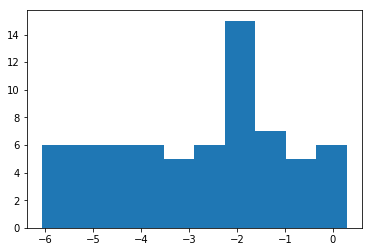

In [116]:
# test = np.where(parsec[np.where((parsec['Zini']==young_30dor_z)&(parsec['logAge']==young_30dor_age))]['Hmag']<=np.max(corabsH[young_dor30]))

# plt.hist(parsec[np.where((parsec['Zini']==young_30dor_z)&(parsec['logAge']==young_30dor_age))]['Hmag'])

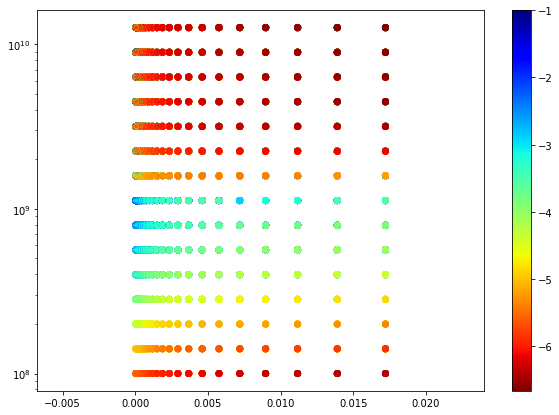

In [93]:
plt.figure(figsize=[10,7])
plt.scatter(parsec['Zini'],10**parsec['logAge'],c=parsec['Hmag'],vmin=-6.665,vmax=-1,cmap='jet_r')
plt.yscale('log')
plt.colorbar()

In [82]:
# print(min(parsec['Hmag']))
# plt.hist(parsec['Hmag'])


In [83]:
# young_30dor_age,young_30dor_z = mc.findclosestparsec((10**np.median(parage[young_dor30]))/10**9,
#                                                      np.median(clndr16[young_dor30]['FE_H']),parsec)

# young_mass30dor = fieldmass(young_30dor_age,young_30dor_z,np.max(corabsH[young_dor30]),
#                               np.min(corabsH[young_dor30]),clndr16[young_dor30]['SELECTFUNC'][0],
#                               len(np.squeeze(young_dor30)),parsec)

In [84]:
# print(young_30dor_age)
# print(young_30dor_z)

## Young Stars

In [74]:
# young_gen_age,young_gen_z = mc.findclosestparsec(young_age,young_feh,parsec)

### Single RGB Fields

#30 Dor
young_30dor_age,young_30dor_z = mc.findclosestparsec((10**np.median(parage[young_dor30]))/10**9,
                                                     np.median(clndr16[young_dor30]['FE_H']),parsec)

young_mass30dor = mc.fieldmass(young_30dor_age,young_30dor_z,np.max(corabsH[young_dor30]),
                              np.min(corabsH[young_dor30]),clndr16[young_dor30]['SELECTFUNC'][0],
                              len(np.squeeze(young_dor30)),parsec)

#LMC 4
young_lmc4_age,young_lmc4_z = mc.findclosestparsec((10**np.median(parage[young_lmc4]))/10**9,
                                                     np.median(clndr16[young_lmc4]['FE_H']),parsec)

young_masslmc4 = mc.fieldmass(young_lmc4_age,young_lmc4_z,np.max(corabsH[young_lmc4]),np.min(corabsH[young_lmc4]),
                        clndr16[young_lmc4]['SELECTFUNC'][0],len(np.squeeze(young_lmc4)),parsec)

#LMC 5
young_lmc5_age,young_lmc5_z = mc.findclosestparsec((10**np.median(parage[young_lmc5]))/10**9,
                                                     np.median(clndr16[young_lmc5]['FE_H']),parsec)

young_masslmc5 = mc.fieldmass(young_lmc5_age,young_lmc5_z,np.max(corabsH[young_lmc5]),np.min(corabsH[young_lmc5]),
                        clndr16[young_lmc5]['SELECTFUNC'][0],len(np.squeeze(young_lmc5)),parsec)

#LMC 6
young_lmc6_age,young_lmc6_z = mc.findclosestparsec((10**np.median(parage[young_lmc6]))/10**9,
                                                     np.median(clndr16[young_lmc6]['FE_H']),parsec)

young_masslmc6 = mc.fieldmass(young_lmc6_age,young_lmc6_z,np.max(corabsH[young_lmc6]),np.min(corabsH[young_lmc6]),
                        clndr16[young_lmc6]['SELECTFUNC'][0],len(np.squeeze(young_lmc6)),parsec)

#LMC 8
young_lmc8_age,young_lmc8_z = mc.findclosestparsec((10**np.median(parage[young_lmc8]))/10**9,
                                                     np.median(clndr16[young_lmc8]['FE_H']),parsec)

young_masslmc8 = mc.fieldmass(young_lmc8_age,young_lmc8_z,np.max(corabsH[young_lmc8]),np.min(corabsH[young_lmc8]),
                        clndr16[young_lmc8]['SELECTFUNC'][0],len(np.squeeze(young_lmc8)),parsec)

#LMC 9
young_lmc9_age,young_lmc9_z = mc.findclosestparsec((10**np.median(parage[young_lmc9]))/10**9,
                                                     np.median(clndr16[young_lmc9]['FE_H']),parsec)

young_masslmc9 = mc.fieldmass(young_lmc9_age,young_lmc9_z,np.max(corabsH[young_lmc9]),np.min(corabsH[young_lmc9]),
                        clndr16[young_lmc9]['SELECTFUNC'][0],len(np.squeeze(young_lmc9)),parsec)

#LMC 13
young_lmc13_age,young_lmc13_z = mc.findclosestparsec((10**np.median(parage[young_lmc13]))/10**9,
                                                     np.median(clndr16[young_lmc13]['FE_H']),parsec)

young_masslmc13 = mc.fieldmass(young_lmc13_age,young_lmc13_z,np.max(corabsH[young_lmc13]),
                               np.min(corabsH[young_lmc13]),clndr16[young_lmc13]['SELECTFUNC'][0],
                               len(np.squeeze(young_lmc13)),parsec)

#LMC 14
young_lmc14_age,young_lmc14_z = mc.findclosestparsec((10**np.median(parage[young_lmc14]))/10**9,
                                                     np.median(clndr16[young_lmc14]['FE_H']),parsec)

young_masslmc14 = mc.fieldmass(young_lmc14_age,young_lmc14_z,np.max(corabsH[young_lmc14]),
                               np.min(corabsH[young_lmc14]),clndr16[young_lmc14]['SELECTFUNC'][0],
                               len(np.squeeze(young_lmc14)),parsec)



In [47]:
# x1 = [1., 0.88,  0.67,  0.50,  0.35,  0.27, 0.18,  0.11,  0.08,  0.04,  0.04,  0.02]
# y1 = [0., 13.99, 27.99, 41.98, 55.98, 69.97, 83.97, 97.97, 111.96, 125.96, 139.95, 153.95]
# points = zip(x1, y1)
# points = sorted(points, key=lambda point: point[0])
# x1, y1 = zip(*points)
# print(x1)
# print(y1)

(0.02, 0.04, 0.04, 0.08, 0.11, 0.18, 0.27, 0.35, 0.5, 0.67, 0.88, 1.0)
(153.95, 125.96, 139.95, 111.96, 97.97, 83.97, 69.97, 55.98, 41.98, 27.99, 13.99, 0.0)


In [51]:

########################################################
### Mass of Fields with composite Bright/Faint stars ###
########################################################

young_fnt1 = np.where(clndr16[young_lmc1]['TARGET_NAME']=='FntRGB')
young_fnt2 = np.where(clndr16[young_lmc2]['TARGET_NAME']=='FntRGB')
young_fnt3 = np.where(clndr16[young_lmc3]['TARGET_NAME']=='FntRGB')
young_fnt7 = np.where(clndr16[young_lmc7]['TARGET_NAME']=='FntRGB')
young_fnt10 = np.where(clndr16[young_lmc10]['TARGET_NAME']=='FntRGB')
young_fnt11 = np.where(clndr16[young_lmc11]['TARGET_NAME']=='FntRGB')
young_fnt12 = np.where(clndr16[young_lmc12]['TARGET_NAME']=='FntRGB')
young_fnt16 = np.where(clndr16[young_lmc16]['TARGET_NAME']=='FntRGB')
young_fnt17 = np.where(clndr16[young_lmc17]['TARGET_NAME']=='FntRGB')

young_brt1 = np.where(clndr16[young_lmc1]['TARGET_NAME']=='BrtRGB')
young_brt2 = np.where(clndr16[young_lmc2]['TARGET_NAME']=='BrtRGB')
young_brt3 = np.where(clndr16[young_lmc3]['TARGET_NAME']=='BrtRGB')
young_brt7 = np.where(clndr16[young_lmc7]['TARGET_NAME']=='BrtRGB')
young_brt10 = np.where(clndr16[young_lmc10]['TARGET_NAME']=='BrtRGB')
young_brt11 = np.where(clndr16[young_lmc11]['TARGET_NAME']=='BrtRGB')
young_brt12 = np.where(clndr16[young_lmc12]['TARGET_NAME']=='BrtRGB')
young_brt16 = np.where(clndr16[young_lmc16]['TARGET_NAME']=='BrtRGB')
young_brt17 = np.where(clndr16[young_lmc17]['TARGET_NAME']=='BrtRGB')

#LMC 1
young_fnt1_age,young_fnt1_z = mc.findclosestparsec((10**np.median(parage[young_lmc1][young_fnt1]))/10**9,
                                                     np.median(clndr16[young_lmc1][young_fnt1]['FE_H']),parsec)

young_fntlmc1 = mc.fieldmass(young_fnt1_age,young_fnt1_z,np.max(corabsH[young_lmc1][young_fnt1]),
                       np.min(corabsH[young_lmc1][young_fnt1]),clndr16[young_lmc1][young_fnt1]['SELECTFUNC'][0],
                       len(np.squeeze(young_fnt1)),parsec)

young_brt1_age,young_brt1_z = mc.findclosestparsec((10**np.median(parage[young_lmc1][young_brt1]))/10**9,
                                                     np.median(clndr16[young_lmc1][young_brt1]['FE_H']),parsec)

young_brtlmc1 = mc.fieldmass(young_brt1_age,young_brt1_z,np.max(corabsH[young_lmc1][young_brt1]),
                       np.min(corabsH[young_lmc1][young_brt1]),clndr16[young_lmc1][young_brt1]['SELECTFUNC'][0],
                       len(np.squeeze(young_lmc1)),parsec)

young_masslmc1 = young_fntlmc1+young_brtlmc1

#LMC 2
young_fnt2_age,young_fnt2_z = mc.findclosestparsec((10**np.median(parage[young_lmc2][young_fnt2]))/10**9,
                                                     np.median(clndr16[young_lmc2][young_fnt2]['FE_H']),parsec)

young_fntlmc2 = mc.fieldmass(young_fnt2_age,young_fnt2_z,np.max(corabsH[young_lmc2][young_fnt2]),
                       np.min(corabsH[young_lmc2][young_fnt2]),clndr16[young_lmc2][young_fnt2]['SELECTFUNC'][0],
                       len(np.squeeze(young_fnt2)),parsec)

young_brt2_age,young_brt2_z = mc.findclosestparsec((10**np.median(parage[young_lmc2][young_brt2]))/10**9,
                                                     np.median(clndr16[young_lmc2][young_brt2]['FE_H']),parsec)

# young_brtlmc2 = mc.fieldmass(young_brt2_age,young_brt2_z,np.max(corabsH[young_lmc2][young_brt2]),
#                        np.min(corabsH[young_lmc2][young_brt2]),clndr16[young_lmc2][young_brt2]['SELECTFUNC'][0],
#                        len(np.squeeze(young_brt2)),parsec)

young_masslmc2 = young_fntlmc2#+young_brtlmc2

#LMC 3
young_fnt3_age,young_fnt3_z = mc.findclosestparsec((10**np.median(parage[young_lmc3][young_fnt3]))/10**9,
                                                     np.median(clndr16[young_lmc3][young_fnt3]['FE_H']),parsec)

young_fntlmc3 = mc.fieldmass(young_fnt3_age,young_fnt3_z,np.max(corabsH[young_lmc3][young_fnt3]),
                       np.min(corabsH[young_lmc3][young_fnt3]),clndr16[young_lmc3][young_fnt3]['SELECTFUNC'][0],
                       len(np.squeeze(young_fnt3)),parsec)

young_brt3_age,young_brt3_z = mc.findclosestparsec((10**np.median(parage[young_lmc3][young_brt3]))/10**9,
                                                     np.median(clndr16[young_lmc3][young_brt3]['FE_H']),parsec)

young_brtlmc3 = mc.fieldmass(young_brt3_age,young_brt3_z,np.max(corabsH[young_lmc3][young_brt3]),
                       np.min(corabsH[young_lmc3][young_brt3]),clndr16[young_lmc3][young_brt3]['SELECTFUNC'][0],
                       len(np.squeeze(young_brt3)),parsec)

young_masslmc3 = young_fntlmc3+young_brtlmc3

#LMC 7
young_fnt7_age,young_fnt7_z = mc.findclosestparsec((10**np.median(parage[young_lmc7][young_fnt7]))/10**9,
                                                     np.median(clndr16[young_lmc7][young_fnt7]['FE_H']),parsec)

young_fntlmc7 = mc.fieldmass(young_fnt7_age,young_fnt7_z,np.max(corabsH[young_lmc7][young_fnt7]),
                       np.min(corabsH[young_lmc7][young_fnt7]),clndr16[young_lmc7][young_fnt7]['SELECTFUNC'][0],
                       len(np.squeeze(young_fnt7)),parsec)

young_brt7_age,young_brt7_z = mc.findclosestparsec((10**np.median(parage[young_lmc7][young_brt7]))/10**9,
                                                     np.median(clndr16[young_lmc7][young_brt7]['FE_H']),parsec)

young_brtlmc7 = mc.fieldmass(young_brt7_age,young_brt7_z,np.max(corabsH[young_lmc7][young_brt7]),
                       np.min(corabsH[young_lmc7][young_brt7]),clndr16[young_lmc7][young_brt7]['SELECTFUNC'][0],
                       len(np.squeeze(young_brt7)),parsec)

young_masslmc7 = young_fntlmc7+young_brtlmc7

#LMC 10
young_fnt10_age,young_fnt10_z = mc.findclosestparsec((10**np.median(parage[young_lmc10][young_fnt10]))/10**9,
                                                     np.median(clndr16[young_lmc10][young_fnt10]['FE_H']),parsec)

young_fntlmc10 = mc.fieldmass(young_fnt10_age,young_fnt10_z,np.max(corabsH[young_lmc10][young_fnt10]),
                       np.min(corabsH[young_lmc10][young_fnt10]),clndr16[young_lmc10][young_fnt10]['SELECTFUNC'][0],
                       len(np.squeeze(young_fnt10)),parsec)

young_brt10_age,young_brt10_z = mc.findclosestparsec((10**np.median(parage[young_lmc10][young_brt10]))/10**9,
                                                     np.median(clndr16[young_lmc10][young_brt10]['FE_H']),parsec)

young_brtlmc10 = mc.fieldmass(young_brt10_age,young_brt10_z,np.max(corabsH[young_lmc10][young_brt10]),
                       np.min(corabsH[young_lmc10][young_brt10]),clndr16[young_lmc10][young_brt10]['SELECTFUNC'][0],
                       len(np.squeeze(young_brt10)),parsec)

young_masslmc10 = young_fntlmc10+young_brtlmc10

#LMC 11
young_fnt11_age,young_fnt11_z = mc.findclosestparsec((10**np.median(parage[young_lmc11][young_fnt11]))/10**9,
                                                     np.median(clndr16[young_lmc11][young_fnt11]['FE_H']),parsec)

young_fntlmc11 = mc.fieldmass(young_fnt11_age,young_fnt11_z,np.max(corabsH[young_lmc11][young_fnt11]),
                       np.min(corabsH[young_lmc11][young_fnt11]),clndr16[young_lmc11][young_fnt11]['SELECTFUNC'][0],
                       len(np.squeeze(young_fnt11)),parsec)

young_brt11_age,young_brt11_z = mc.findclosestparsec((10**np.median(parage[young_lmc11][young_brt11]))/10**9,
                                                     np.median(clndr16[young_lmc11][young_brt11]['FE_H']),parsec)

young_brtlmc11 = mc.fieldmass(young_brt11_age,young_brt11_z,np.max(corabsH[young_lmc11][young_brt11]),
                       np.min(corabsH[young_lmc11][young_brt11]),clndr16[young_lmc11][young_brt11]['SELECTFUNC'][0],
                       len(np.squeeze(young_brt11)),parsec)

young_masslmc11 = young_fntlmc11+young_brtlmc11

#LMC 12
young_fnt12_age,young_fnt12_z = mc.findclosestparsec((10**np.median(parage[young_lmc12][young_fnt12]))/10**9,
                                                     np.median(clndr16[young_lmc12][young_fnt12]['FE_H']),parsec)

young_fntlmc12 = mc.fieldmass(young_fnt12_age,young_fnt12_z,np.max(corabsH[young_lmc12][young_fnt12]),
                       np.min(corabsH[young_lmc12][young_fnt12]),clndr16[young_lmc12][young_fnt12]['SELECTFUNC'][0],
                       len(np.squeeze(young_fnt12)),parsec)

young_brt12_age,young_brt12_z = mc.findclosestparsec((10**np.median(parage[young_lmc12][young_brt12]))/10**9,
                                                     np.median(clndr16[young_lmc12][young_brt12]['FE_H']),parsec)

# young_brtlmc12 = mc.fieldmass(young_brt12_age,young_brt12_z,np.max(corabsH[young_lmc12][young_brt12]),
#                        np.min(corabsH[young_lmc12][young_brt12]),clndr16[young_lmc12][young_brt12]['SELECTFUNC'][0],
#                        len(np.squeeze(young_brt12)),parsec)

young_masslmc12 = young_fntlmc12#+young_brtlmc12

#LMC 16
young_fnt16_age,young_fnt16_z = mc.findclosestparsec((10**np.median(parage[young_lmc16][young_fnt16]))/10**9,
                                                     np.median(clndr16[young_lmc16][young_fnt16]['FE_H']),parsec)

young_fntlmc16 = mc.fieldmass(young_fnt16_age,young_fnt16_z,np.max(corabsH[young_lmc16][young_fnt16]),
                       np.min(corabsH[young_lmc16][young_fnt16]),clndr16[young_lmc16][young_fnt16]['SELECTFUNC'][0],
                       len(np.squeeze(young_fnt16)),parsec)

young_brt16_age,young_brt16_z = mc.findclosestparsec((10**np.median(parage[young_lmc16][young_brt16]))/10**9,
                                                     np.median(clndr16[young_lmc16][young_brt16]['FE_H']),parsec)

# young_brtlmc16 = mc.fieldmass(young_brt16_age,young_brt16_z,np.max(corabsH[young_lmc16][young_brt16]),
#                        np.min(corabsH[young_lmc16][young_brt16]),clndr16[young_lmc16][young_brt16]['SELECTFUNC'][0],
#                        len(np.squeeze(young_brt16)),parsec)

young_masslmc16 = young_fntlmc16#+young_brtlmc16

#LMC 17
young_fnt17_age,young_fnt17_z = mc.findclosestparsec((10**np.median(parage[young_lmc17][young_fnt17]))/10**9,
                                                     np.median(clndr16[young_lmc17][young_fnt17]['FE_H']),parsec)

young_fntlmc17 = mc.fieldmass(young_fnt17_age,young_fnt17_z,np.max(corabsH[young_lmc17][young_fnt17]),
                       np.min(corabsH[young_lmc17][young_fnt17]),clndr16[young_lmc17][young_fnt17]['SELECTFUNC'][0],
                       len(np.squeeze(young_fnt17)),parsec)

young_brt17_age,young_brt17_z = mc.findclosestparsec((10**np.median(parage[young_lmc17][young_brt17]))/10**9,
                                                     np.median(clndr16[young_lmc17][young_brt17]['FE_H']),parsec)

# young_brtlmc17 = mc.fieldmass(young_brt17_age,young_brt17_z,np.max(corabsH[young_lmc17][young_brt17]),
#                        np.min(corabsH[young_lmc17][young_brt17]),clndr16[young_lmc17][young_brt17]['SELECTFUNC'][0],
#                        len(np.squeeze(young_brt17)),parsec)

young_masslmc17 = young_fntlmc17#+young_brtlmc17


In [140]:
young_bloop = np.where((clndr16['TEFF'][young]>=4100)&(clndr16['H'][young]<=13.0)&
                 ((clndr16['J']-clndr16['K'])[young]<=0.95))

young_bloop_cut = []
for i in range(len(clndr16[young])):
    if i not in np.squeeze(young_bloop).tolist():
        young_bloop_cut.append(i)

young_r13bloop_cut = clndr16[young_bloop_cut]

young_area30dor = ac.apogee_field_area('30Dor',young_r13bloop_cut)
young_arealmc1 = np.nan #ac.apogee_field_area('LMC1',young_r13bloop_cut)
young_arealmc2 = np.nan #ac.apogee_field_area('LMC2',young_r13bloop_cut)
young_arealmc3 = np.nan #ac.apogee_field_area('LMC3',young_r13bloop_cut)
young_arealmc4 = ac.apogee_field_area('LMC4',young_r13bloop_cut)
young_arealmc5 = ac.apogee_field_area('LMC5',young_r13bloop_cut)
young_arealmc6 = np.nan #ac.apogee_field_area('LMC6',young_r13bloop_cut)
young_arealmc7 = np.nan #ac.apogee_field_area('LMC7',young_r13bloop_cut)
young_arealmc8 = ac.apogee_field_area('LMC8',young_r13bloop_cut)
young_arealmc9 = ac.apogee_field_area('LMC9',young_r13bloop_cut)
young_arealmc10 = np.nan #ac.apogee_field_area('LMC10',young_r13bloop_cut)
young_arealmc11 = np.nan #ac.apogee_field_area('LMC11',young_r13bloop_cut)
young_arealmc12 = np.nan #ac.apogee_field_area('LMC12',young_r13bloop_cut)
young_arealmc13 = ac.apogee_field_area('LMC13',young_r13bloop_cut)
young_arealmc14 = ac.apogee_field_area('LMC14',young_r13bloop_cut)
young_arealmc16 = np.nan #ac.apogee_field_area('LMC16',young_r13bloop_cut)
young_arealmc17 = np.nan #ac.apogee_field_area('LMC17',young_r13bloop_cut)

young_areas = [young_area30dor,young_arealmc1,young_arealmc2,young_arealmc3,young_arealmc4,young_arealmc5,
               young_arealmc6,young_arealmc7,young_arealmc8,young_arealmc9,young_arealmc10,young_arealmc11,
               young_arealmc12,young_arealmc13,young_arealmc14,young_arealmc16,young_arealmc17]

In [141]:
young_masses = [young_mass30dor,np.nan,young_masslmc2,young_masslmc3,young_masslmc4,young_masslmc5,
                young_masslmc6,young_masslmc7,young_masslmc8,young_masslmc9,young_masslmc10,young_masslmc11,
                young_masslmc12,young_masslmc13,young_masslmc14,young_masslmc16,young_masslmc17]
# young_masses

                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                    7
Model:                            RLM   Df Residuals:                        5
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 04 Mar 2020                                         
Time:                        21:39:18                                         
No. Iterations:                     2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.4221      3.194     -1.384      0.1

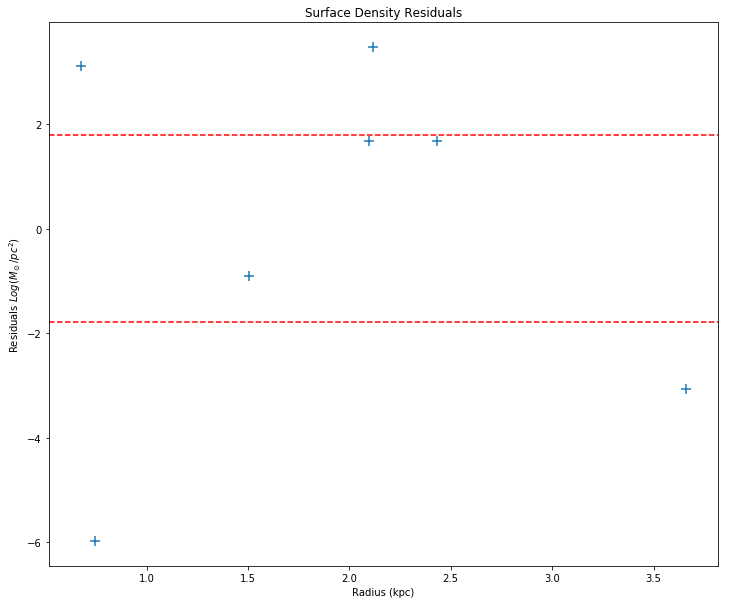

mad(Residual): 1.7858812184526824


In [142]:
# young_good = np.where(np.asarray(young_masses)!=-9999.0)

young_bdor30 = np.where(young_r13bloop_cut['Field']=='30Dor')
young_blmc1 = np.where(young_r13bloop_cut['Field']=='LMC1')
young_blmc2 = np.where(young_r13bloop_cut['Field']=='LMC2')
young_blmc3 = np.where(young_r13bloop_cut['Field']=='LMC3')
young_blmc4 = np.where(young_r13bloop_cut['Field']=='LMC4')
young_blmc5 = np.where(young_r13bloop_cut['Field']=='LMC5')
young_blmc6 = np.where(young_r13bloop_cut['Field']=='LMC6')
young_blmc7 = np.where(young_r13bloop_cut['Field']=='LMC7')
young_blmc8 = np.where(young_r13bloop_cut['Field']=='LMC8')
young_blmc9 = np.where(young_r13bloop_cut['Field']=='LMC9')
young_blmc10 = np.where(young_r13bloop_cut['Field']=='LMC10')
young_blmc11 = np.where(young_r13bloop_cut['Field']=='LMC11')
young_blmc12 = np.where(young_r13bloop_cut['Field']=='LMC12')
young_blmc13 = np.where(young_r13bloop_cut['Field']=='LMC13')
young_blmc14 = np.where(young_r13bloop_cut['Field']=='LMC14')
young_blmc16 = np.where(young_r13bloop_cut['Field']=='LMC16')
young_blmc17 = np.where(young_r13bloop_cut['Field']=='LMC17')

young_fields = [young_bdor30,young_blmc1,young_blmc2,young_blmc3,young_blmc4,young_blmc5,young_blmc6,young_blmc7,
          young_blmc8,young_blmc9,young_blmc10,young_blmc11,young_blmc12,young_blmc13,young_blmc14,young_blmc16,
          young_blmc17]

young_radii = []
# angles = []
young_surfden = []
for i in range(len(young_fields)):
    young_radii.append(np.sqrt(np.median(LMCdisk_cart(young_r13bloop_cut['RA'][young_fields[i]],
                                                young_r13bloop_cut['DEC'][young_fields[i]])[0])**2+
                         np.median(LMCdisk_cart(young_r13bloop_cut['RA'][young_fields[i]],
                                                young_r13bloop_cut['DEC'][young_fields[i]])[1])**2))
    
    young_surfden.append((young_masses[i]/young_areas[i]))
    
young_good = np.where(np.isfinite(young_radii)==True)

model = (np.asarray(young_radii)[young_good]).T#np.array([young_radii]).T
model = sm.add_constant(model)
model_model = sm.RLM(np.log(np.divide((np.asarray(young_surfden)[young_good]),10**6)),model).fit()
model_predictions = model_model.predict(model)
model_residual = model_predictions - np.log(np.divide((np.asarray(young_surfden)[young_good]),10**6))
model_summary = model_model.summary()
print(model_summary)
print(np.asarray(model_model.params))
plt.figure(figsize=[12,10])
plt.scatter(np.asarray(young_radii)[young_good],model_residual,marker='+',label='Residuals',cmap='nipy_spectral',
            s=100)
plt.axhline(mad(model_residual),linestyle='--',c='r',label='MAD')
plt.axhline(-mad(model_residual),linestyle='--',c='r')
plt.title(r'Surface Density Residuals')
plt.xlabel(r'Radius (kpc)')
plt.ylabel(r'Residuals $Log(M_\odot/pc^2)$')
# plt.colorbar()
# plt.savefig('residexpmodel.pdf',bbox_inches='tight')
plt.show()
print('mad(Residual):',mad(model_residual))

In [108]:
[0,3,4,7,8,12,13]

array([[1.        , 0.74485355],
       [1.        ,        nan],
       [1.        ,        nan],
       [1.        , 3.6620863 ],
       [1.        , 2.43252107],
       [1.        ,        nan],
       [1.        ,        nan],
       [1.        , 2.11426205],
       [1.        , 0.67521232],
       [1.        ,        nan],
       [1.        ,        nan],
       [1.        ,        nan],
       [1.        , 1.50516733],
       [1.        , 2.0950209 ],
       [1.        ,        nan],
       [1.        ,        nan]])

In [110]:
young_radii

[0.7448535474414818,
 nan,
 nan,
 3.662086297245416,
 2.4325210671299105,
 nan,
 nan,
 2.1142620503703067,
 0.6752123177910292,
 nan,
 nan,
 nan,
 1.5051673308631799,
 2.095020901997325,
 nan,
 nan]

## ymed

In [185]:
### Single RGB Fields

#30 Dor
ymed_30dor_age,ymed_30dor_z = mc.findclosestparsec((10**np.median(parage[ymed_dor30]))/10**9,
                                                     np.median(clndr16[ymed_dor30]['FE_H']),parsec)

ymed_mass30dor = mc.fieldmass(ymed_30dor_age,ymed_30dor_z,np.max(corabsH[ymed_dor30]),
                              np.min(corabsH[ymed_dor30]),clndr16[ymed_dor30]['SELECTFUNC'][0],
                              len(np.squeeze(ymed_dor30)),parsec)

#LMC 4
ymed_lmc4_age,ymed_lmc4_z = mc.findclosestparsec((10**np.median(parage[ymed_lmc4]))/10**9,
                                                     np.median(clndr16[ymed_lmc4]['FE_H']),parsec)

ymed_masslmc4 = mc.fieldmass(ymed_lmc4_age,ymed_lmc4_z,np.max(corabsH[ymed_lmc4]),np.min(corabsH[ymed_lmc4]),
                        clndr16[ymed_lmc4]['SELECTFUNC'][0],len(np.squeeze(ymed_lmc4)),parsec)

#LMC 5
ymed_lmc5_age,ymed_lmc5_z = mc.findclosestparsec((10**np.median(parage[ymed_lmc5]))/10**9,
                                                     np.median(clndr16[ymed_lmc5]['FE_H']),parsec)

ymed_masslmc5 = mc.fieldmass(ymed_lmc5_age,ymed_lmc5_z,np.max(corabsH[ymed_lmc5]),np.min(corabsH[ymed_lmc5]),
                        clndr16[ymed_lmc5]['SELECTFUNC'][0],len(np.squeeze(ymed_lmc5)),parsec)

#LMC 6
ymed_lmc6_age,ymed_lmc6_z = mc.findclosestparsec((10**np.median(parage[ymed_lmc6]))/10**9,
                                                     np.median(clndr16[ymed_lmc6]['FE_H']),parsec)

ymed_masslmc6 = mc.fieldmass(ymed_lmc6_age,ymed_lmc6_z,np.max(corabsH[ymed_lmc6]),np.min(corabsH[ymed_lmc6]),
                        clndr16[ymed_lmc6]['SELECTFUNC'][0],len(np.squeeze(ymed_lmc6)),parsec)

#LMC 8
ymed_lmc8_age,ymed_lmc8_z = mc.findclosestparsec((10**np.median(parage[ymed_lmc8]))/10**9,
                                                     np.median(clndr16[ymed_lmc8]['FE_H']),parsec)

ymed_masslmc8 = mc.fieldmass(ymed_lmc8_age,ymed_lmc8_z,np.max(corabsH[ymed_lmc8]),np.min(corabsH[ymed_lmc8]),
                        clndr16[ymed_lmc8]['SELECTFUNC'][0],len(np.squeeze(ymed_lmc8)),parsec)

#LMC 9
ymed_lmc9_age,ymed_lmc9_z = mc.findclosestparsec((10**np.median(parage[ymed_lmc9]))/10**9,
                                                     np.median(clndr16[ymed_lmc9]['FE_H']),parsec)

ymed_masslmc9 = mc.fieldmass(ymed_lmc9_age,ymed_lmc9_z,np.max(corabsH[ymed_lmc9]),np.min(corabsH[ymed_lmc9]),
                        clndr16[ymed_lmc9]['SELECTFUNC'][0],len(np.squeeze(ymed_lmc9)),parsec)

#LMC 13
ymed_lmc13_age,ymed_lmc13_z = mc.findclosestparsec((10**np.median(parage[ymed_lmc13]))/10**9,
                                                     np.median(clndr16[ymed_lmc13]['FE_H']),parsec)

ymed_masslmc13 = mc.fieldmass(ymed_lmc13_age,ymed_lmc13_z,np.max(corabsH[ymed_lmc13]),
                               np.min(corabsH[ymed_lmc13]),clndr16[ymed_lmc13]['SELECTFUNC'][0],
                               len(np.squeeze(ymed_lmc13)),parsec)

#LMC 14
ymed_lmc14_age,ymed_lmc14_z = mc.findclosestparsec((10**np.median(parage[ymed_lmc14]))/10**9,
                                                     np.median(clndr16[ymed_lmc14]['FE_H']),parsec)

ymed_masslmc14 = mc.fieldmass(ymed_lmc14_age,ymed_lmc14_z,np.max(corabsH[ymed_lmc14]),
                               np.min(corabsH[ymed_lmc14]),clndr16[ymed_lmc14]['SELECTFUNC'][0],
                               len(np.squeeze(ymed_lmc14)),parsec)

In [58]:
ymed_fnt1 = np.where(clndr16[ymed_lmc1]['TARGET_NAME']=='FntRGB')
ymed_fnt2 = np.where(clndr16[ymed_lmc2]['TARGET_NAME']=='FntRGB')
ymed_fnt3 = np.where(clndr16[ymed_lmc3]['TARGET_NAME']=='FntRGB')
ymed_fnt7 = np.where(clndr16[ymed_lmc7]['TARGET_NAME']=='FntRGB')
ymed_fnt10 = np.where(clndr16[ymed_lmc10]['TARGET_NAME']=='FntRGB')
ymed_fnt11 = np.where(clndr16[ymed_lmc11]['TARGET_NAME']=='FntRGB')
ymed_fnt12 = np.where(clndr16[ymed_lmc12]['TARGET_NAME']=='FntRGB')
ymed_fnt16 = np.where(clndr16[ymed_lmc16]['TARGET_NAME']=='FntRGB')
ymed_fnt17 = np.where(clndr16[ymed_lmc17]['TARGET_NAME']=='FntRGB')

ymed_brt1 = np.where(clndr16[ymed_lmc1]['TARGET_NAME']=='BrtRGB')
ymed_brt2 = np.where(clndr16[ymed_lmc2]['TARGET_NAME']=='BrtRGB')
ymed_brt3 = np.where(clndr16[ymed_lmc3]['TARGET_NAME']=='BrtRGB')
ymed_brt7 = np.where(clndr16[ymed_lmc7]['TARGET_NAME']=='BrtRGB')
ymed_brt10 = np.where(clndr16[ymed_lmc10]['TARGET_NAME']=='BrtRGB')
ymed_brt11 = np.where(clndr16[ymed_lmc11]['TARGET_NAME']=='BrtRGB')
ymed_brt12 = np.where(clndr16[ymed_lmc12]['TARGET_NAME']=='BrtRGB')
ymed_brt16 = np.where(clndr16[ymed_lmc16]['TARGET_NAME']=='BrtRGB')
ymed_brt17 = np.where(clndr16[ymed_lmc17]['TARGET_NAME']=='BrtRGB')

#LMC 1
ymed_fnt1_age,ymed_fnt1_z = mc.findclosestparsec((10**np.median(parage[ymed_lmc1][ymed_fnt1]))/10**9,
                                                     np.median(clndr16[ymed_lmc1][ymed_fnt1]['FE_H']),parsec)

# ymed_fntlmc1 = mc.fieldmass(ymed_fnt1_age,ymed_fnt1_z,np.max(corabsH[ymed_lmc1][ymed_fnt1]),
#                        np.min(corabsH[ymed_lmc1][ymed_fnt1]),clndr16[ymed_lmc1][ymed_fnt1]['SELECTFUNC'][0],
#                        len(np.squeeze(ymed_fnt1)),parsec)

ymed_brt1_age,ymed_brt1_z = mc.findclosestparsec((10**np.median(parage[ymed_lmc1][ymed_brt1]))/10**9,
                                                     np.median(clndr16[ymed_lmc1][ymed_brt1]['FE_H']),parsec)

ymed_brtlmc1 = mc.fieldmass(ymed_brt1_age,ymed_brt1_z,np.max(corabsH[ymed_lmc1][ymed_brt1]),
                       np.min(corabsH[ymed_lmc1][ymed_brt1]),clndr16[ymed_lmc1][ymed_brt1]['SELECTFUNC'][0],
                       len(np.squeeze(ymed_brt1)),parsec)

ymed_masslmc1 = ymed_brtlmc1 #ymed_fntlmc1+ymed_brtlmc1

#LMC 2
ymed_fnt2_age,ymed_fnt2_z = mc.findclosestparsec((10**np.median(parage[ymed_lmc2][ymed_fnt2]))/10**9,
                                                     np.median(clndr16[ymed_lmc2][ymed_fnt2]['FE_H']),parsec)

ymed_fntlmc2 = mc.fieldmass(ymed_fnt2_age,ymed_fnt2_z,np.max(corabsH[ymed_lmc2][ymed_fnt2]),
                       np.min(corabsH[ymed_lmc2][ymed_fnt2]),clndr16[ymed_lmc2][ymed_fnt2]['SELECTFUNC'][0],
                       len(np.squeeze(ymed_fnt2)),parsec)

ymed_brt2_age,ymed_brt2_z = mc.findclosestparsec((10**np.median(parage[ymed_lmc2][ymed_brt2]))/10**9,
                                                     np.median(clndr16[ymed_lmc2][ymed_brt2]['FE_H']),parsec)

ymed_brtlmc2 = mc.fieldmass(ymed_brt2_age,ymed_brt2_z,np.max(corabsH[ymed_lmc2][ymed_brt2]),
                       np.min(corabsH[ymed_lmc2][ymed_brt2]),clndr16[ymed_lmc2][ymed_brt2]['SELECTFUNC'][0],
                       len(np.squeeze(ymed_brt2)),parsec)

ymed_masslmc2 = ymed_fntlmc2+ymed_brtlmc2

#LMC 3
ymed_fnt3_age,ymed_fnt3_z = mc.findclosestparsec((10**np.median(parage[ymed_lmc3][ymed_fnt3]))/10**9,
                                                     np.median(clndr16[ymed_lmc3][ymed_fnt3]['FE_H']),parsec)

ymed_fntlmc3 = mc.fieldmass(ymed_fnt3_age,ymed_fnt3_z,np.max(corabsH[ymed_lmc3][ymed_fnt3]),
                       np.min(corabsH[ymed_lmc3][ymed_fnt3]),clndr16[ymed_lmc3][ymed_fnt3]['SELECTFUNC'][0],
                       len(np.squeeze(ymed_fnt3)),parsec)

ymed_brt3_age,ymed_brt3_z = mc.findclosestparsec((10**np.median(parage[ymed_lmc3][ymed_brt3]))/10**9,
                                                     np.median(clndr16[ymed_lmc3][ymed_brt3]['FE_H']),parsec)

ymed_brtlmc3 = mc.fieldmass(ymed_brt3_age,ymed_brt3_z,np.max(corabsH[ymed_lmc3][ymed_brt3]),
                       np.min(corabsH[ymed_lmc3][ymed_brt3]),clndr16[ymed_lmc3][ymed_brt3]['SELECTFUNC'][0],
                       len(np.squeeze(ymed_brt3)),parsec)

ymed_masslmc3 = ymed_fntlmc3+ymed_brtlmc3

#LMC 7
ymed_fnt7_age,ymed_fnt7_z = mc.findclosestparsec((10**np.median(parage[ymed_lmc7][ymed_fnt7]))/10**9,
                                                     np.median(clndr16[ymed_lmc7][ymed_fnt7]['FE_H']),parsec)

# ymed_fntlmc7 = mc.fieldmass(ymed_fnt7_age,ymed_fnt7_z,np.max(corabsH[ymed_lmc7][ymed_fnt7]),
#                        np.min(corabsH[ymed_lmc7][ymed_fnt7]),clndr16[ymed_lmc7][ymed_fnt7]['SELECTFUNC'][0],
#                        len(np.squeeze(ymed_fnt7)),parsec)

ymed_brt7_age,ymed_brt7_z = mc.findclosestparsec((10**np.median(parage[ymed_lmc7][ymed_brt7]))/10**9,
                                                     np.median(clndr16[ymed_lmc7][ymed_brt7]['FE_H']),parsec)

ymed_brtlmc7 = mc.fieldmass(ymed_brt7_age,ymed_brt7_z,np.max(corabsH[ymed_lmc7][ymed_brt7]),
                       np.min(corabsH[ymed_lmc7][ymed_brt7]),clndr16[ymed_lmc7][ymed_brt7]['SELECTFUNC'][0],
                       len(np.squeeze(ymed_brt7)),parsec)

ymed_masslmc7 = ymed_brtlmc7 #ymed_fntlmc7+ymed_brtlmc7

#LMC 10
ymed_fnt10_age,ymed_fnt10_z = mc.findclosestparsec((10**np.median(parage[ymed_lmc10][ymed_fnt10]))/10**9,
                                                     np.median(clndr16[ymed_lmc10][ymed_fnt10]['FE_H']),parsec)

# ymed_fntlmc10 = mc.fieldmass(ymed_fnt10_age,ymed_fnt10_z,np.max(corabsH[ymed_lmc10][ymed_fnt10]),
#                        np.min(corabsH[ymed_lmc10][ymed_fnt10]),clndr16[ymed_lmc10][ymed_fnt10]['SELECTFUNC'][0],
#                        len(np.squeeze(ymed_fnt10)),parsec)

ymed_brt10_age,ymed_brt10_z = mc.findclosestparsec((10**np.median(parage[ymed_lmc10][ymed_brt10]))/10**9,
                                                     np.median(clndr16[ymed_lmc10][ymed_brt10]['FE_H']),parsec)

ymed_brtlmc10 = mc.fieldmass(ymed_brt10_age,ymed_brt10_z,np.max(corabsH[ymed_lmc10][ymed_brt10]),
                       np.min(corabsH[ymed_lmc10][ymed_brt10]),clndr16[ymed_lmc10][ymed_brt10]['SELECTFUNC'][0],
                       len(np.squeeze(ymed_brt10)),parsec)

ymed_masslmc10 = ymed_brtlmc10 #ymed_fntlmc10+ymed_brtlmc10

#LMC 11
ymed_fnt11_age,ymed_fnt11_z = mc.findclosestparsec((10**np.median(parage[ymed_lmc11][ymed_fnt11]))/10**9,
                                                     np.median(clndr16[ymed_lmc11][ymed_fnt11]['FE_H']),parsec)

ymed_fntlmc11 = mc.fieldmass(ymed_fnt11_age,ymed_fnt11_z,np.max(corabsH[ymed_lmc11][ymed_fnt11]),
                       np.min(corabsH[ymed_lmc11][ymed_fnt11]),clndr16[ymed_lmc11][ymed_fnt11]['SELECTFUNC'][0],
                       len(np.squeeze(ymed_fnt11)),parsec)

ymed_brt11_age,ymed_brt11_z = mc.findclosestparsec((10**np.median(parage[ymed_lmc11][ymed_brt11]))/10**9,
                                                     np.median(clndr16[ymed_lmc11][ymed_brt11]['FE_H']),parsec)

ymed_brtlmc11 = mc.fieldmass(ymed_brt11_age,ymed_brt11_z,np.max(corabsH[ymed_lmc11][ymed_brt11]),
                       np.min(corabsH[ymed_lmc11][ymed_brt11]),clndr16[ymed_lmc11][ymed_brt11]['SELECTFUNC'][0],
                       len(np.squeeze(ymed_brt11)),parsec)

ymed_masslmc11 = ymed_fntlmc11+ymed_brtlmc11

#LMC 12
ymed_fnt12_age,ymed_fnt12_z = mc.findclosestparsec((10**np.median(parage[ymed_lmc12][ymed_fnt12]))/10**9,
                                                     np.median(clndr16[ymed_lmc12][ymed_fnt12]['FE_H']),parsec)

# ymed_fntlmc12 = mc.fieldmass(ymed_fnt12_age,ymed_fnt12_z,np.max(corabsH[ymed_lmc12][ymed_fnt12]),
#                        np.min(corabsH[ymed_lmc12][ymed_fnt12]),clndr16[ymed_lmc12][ymed_fnt12]['SELECTFUNC'][0],
#                        len(np.squeeze(ymed_fnt12)),parsec)

ymed_brt12_age,ymed_brt12_z = mc.findclosestparsec((10**np.median(parage[ymed_lmc12][ymed_brt12]))/10**9,
                                                     np.median(clndr16[ymed_lmc12][ymed_brt12]['FE_H']),parsec)

# ymed_brtlmc12 = mc.fieldmass(ymed_brt12_age,ymed_brt12_z,np.max(corabsH[ymed_lmc12][ymed_brt12]),
#                        np.min(corabsH[ymed_lmc12][ymed_brt12]),clndr16[ymed_lmc12][ymed_brt12]['SELECTFUNC'][0],
#                        len(np.squeeze(ymed_brt12)),parsec)

#ymed_masslmc12 = ymed_brtlmc12 #ymed_fntlmc12+ymed_brtlmc12

#LMC 16
ymed_fnt16_age,ymed_fnt16_z = mc.findclosestparsec((10**np.median(parage[ymed_lmc16][ymed_fnt16]))/10**9,
                                                     np.median(clndr16[ymed_lmc16][ymed_fnt16]['FE_H']),parsec)

ymed_fntlmc16 = mc.fieldmass(ymed_fnt16_age,ymed_fnt16_z,np.max(corabsH[ymed_lmc16][ymed_fnt16]),
                       np.min(corabsH[ymed_lmc16][ymed_fnt16]),clndr16[ymed_lmc16][ymed_fnt16]['SELECTFUNC'][0],
                       len(np.squeeze(ymed_fnt16)),parsec)

ymed_brt16_age,ymed_brt16_z = mc.findclosestparsec((10**np.median(parage[ymed_lmc16][ymed_brt16]))/10**9,
                                                     np.median(clndr16[ymed_lmc16][ymed_brt16]['FE_H']),parsec)

ymed_brtlmc16 = mc.fieldmass(ymed_brt16_age,ymed_brt16_z,np.max(corabsH[ymed_lmc16][ymed_brt16]),
                       np.min(corabsH[ymed_lmc16][ymed_brt16]),clndr16[ymed_lmc16][ymed_brt16]['SELECTFUNC'][0],
                       len(np.squeeze(ymed_brt16)),parsec)

ymed_masslmc16 = ymed_fntlmc16+ymed_brtlmc16

#LMC 17
ymed_fnt17_age,ymed_fnt17_z = mc.findclosestparsec((10**np.median(parage[ymed_lmc17][ymed_fnt17]))/10**9,
                                                     np.median(clndr16[ymed_lmc17][ymed_fnt17]['FE_H']),parsec)

ymed_fntlmc17 = mc.fieldmass(ymed_fnt17_age,ymed_fnt17_z,np.max(corabsH[ymed_lmc17][ymed_fnt17]),
                       np.min(corabsH[ymed_lmc17][ymed_fnt17]),clndr16[ymed_lmc17][ymed_fnt17]['SELECTFUNC'][0],
                       len(np.squeeze(ymed_fnt17)),parsec)

ymed_brt17_age,ymed_brt17_z = mc.findclosestparsec((10**np.median(parage[ymed_lmc17][ymed_brt17]))/10**9,
                                                     np.median(clndr16[ymed_lmc17][ymed_brt17]['FE_H']),parsec)

ymed_brtlmc17 = mc.fieldmass(ymed_brt17_age,ymed_brt17_z,np.max(corabsH[ymed_lmc17][ymed_brt17]),
                       np.min(corabsH[ymed_lmc17][ymed_brt17]),clndr16[ymed_lmc17][ymed_brt17]['SELECTFUNC'][0],
                       len(np.squeeze(ymed_brt17)),parsec)

ymed_masslmc17 = ymed_fntlmc17+ymed_brtlmc17


In [134]:
ymed_bloop = np.where((clndr16['TEFF'][ymed]>=4100)&(clndr16['H'][ymed]<=13.0)&
                 ((clndr16['J']-clndr16['K'])[ymed]<=0.95))

ymed_bloop_cut = []
for i in range(len(clndr16[ymed])):
    if i not in np.squeeze(ymed_bloop).tolist():
        ymed_bloop_cut.append(i)

ymed_r13bloop_cut = clndr16[ymed_bloop_cut]

ymed_area30dor = ac.apogee_field_area('30Dor',ymed_r13bloop_cut)
ymed_arealmc1 = np.nan #ac.apogee_field_area('LMC1',ymed_r13bloop_cut)
ymed_arealmc2 = np.nan #ac.apogee_field_area('LMC2',ymed_r13bloop_cut)
ymed_arealmc3 = np.nan #ac.apogee_field_area('LMC3',ymed_r13bloop_cut)
ymed_arealmc4 = np.nan #ac.apogee_field_area('LMC4',ymed_r13bloop_cut)
ymed_arealmc5 = np.nan #ac.apogee_field_area('LMC5',ymed_r13bloop_cut)
ymed_arealmc6 = np.nan #ac.apogee_field_area('LMC6',ymed_r13bloop_cut)
ymed_arealmc7 = np.nan #ac.apogee_field_area('LMC7',ymed_r13bloop_cut)
ymed_arealmc8 = np.nan #ac.apogee_field_area('LMC8',ymed_r13bloop_cut)
ymed_arealmc9 = np.nan #ac.apogee_field_area('LMC9',ymed_r13bloop_cut)
ymed_arealmc10 = np.nan #ac.apogee_field_area('LMC10',ymed_r13bloop_cut)
ymed_arealmc11 = np.nan #ac.apogee_field_area('LMC11',ymed_r13bloop_cut)
ymed_arealmc12 = np.nan #ac.apogee_field_area('LMC12',ymed_r13bloop_cut)
ymed_arealmc13 = ac.apogee_field_area('LMC13',ymed_r13bloop_cut)
ymed_arealmc14 = ac.apogee_field_area('LMC14',ymed_r13bloop_cut)
ymed_arealmc16 = np.nan #ac.apogee_field_area('LMC16',ymed_r13bloop_cut)
ymed_arealmc17 = np.nan #ac.apogee_field_area('LMC17',ymed_r13bloop_cut)

ymed_areas = [ymed_area30dor,ymed_arealmc1,ymed_arealmc2,ymed_arealmc3,ymed_arealmc4,ymed_arealmc5,
               ymed_arealmc6,ymed_arealmc7,ymed_arealmc8,ymed_arealmc9,ymed_arealmc10,ymed_arealmc11,
               ymed_arealmc12,ymed_arealmc13,ymed_arealmc14,ymed_arealmc16,ymed_arealmc17]

In [186]:
ymed_masses = [ymed_mass30dor,ymed_masslmc1,ymed_masslmc2,ymed_masslmc3,ymed_masslmc4,ymed_masslmc5,
                ymed_masslmc6,ymed_masslmc7,ymed_masslmc8,ymed_masslmc9,ymed_masslmc10,ymed_masslmc11,
                np.nan,ymed_masslmc13,ymed_masslmc14,ymed_masslmc16,ymed_masslmc17]

In [149]:
print(np.where(np.isfinite(ymed_surfden)!=True))
print(np.where(np.isfinite(ymed_radii)!=True))

(array([ 4,  5, 12]),)
(array([ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 15, 16]),)


                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                    3
Model:                            RLM   Df Residuals:                        1
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 04 Mar 2020                                         
Time:                        22:04:13                                         
No. Iterations:                     2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.6165      1.422      3.950      0.0

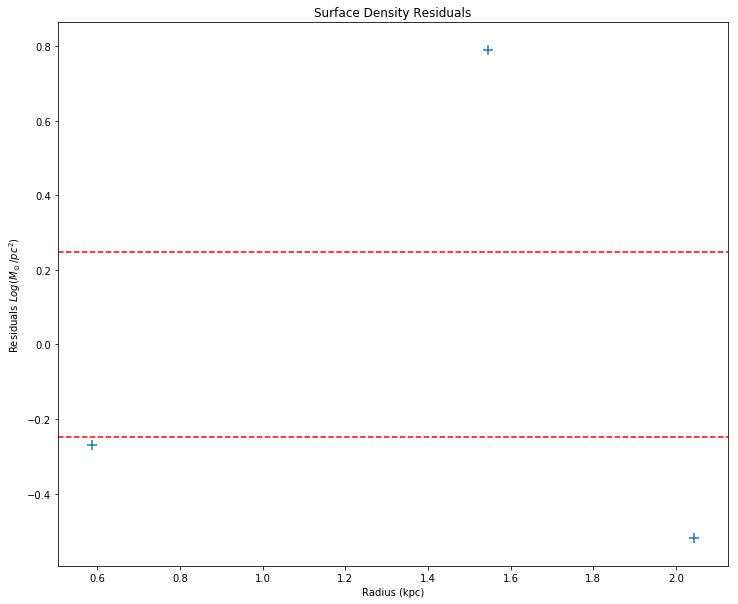

mad(Residual): 0.24742500434324333


In [187]:
ymed_bdor30 = np.where(ymed_r13bloop_cut['Field']=='30Dor')
ymed_blmc1 = np.where(ymed_r13bloop_cut['Field']=='LMC1')
ymed_blmc2 = np.where(ymed_r13bloop_cut['Field']=='LMC2')
ymed_blmc3 = np.where(ymed_r13bloop_cut['Field']=='LMC3')
ymed_blmc4 = np.where(ymed_r13bloop_cut['Field']=='LMC4')
ymed_blmc5 = np.where(ymed_r13bloop_cut['Field']=='LMC5')
ymed_blmc6 = np.where(ymed_r13bloop_cut['Field']=='LMC6')
ymed_blmc7 = np.where(ymed_r13bloop_cut['Field']=='LMC7')
ymed_blmc8 = np.where(ymed_r13bloop_cut['Field']=='LMC8')
ymed_blmc9 = np.where(ymed_r13bloop_cut['Field']=='LMC9')
ymed_blmc10 = np.where(ymed_r13bloop_cut['Field']=='LMC10')
ymed_blmc11 = np.where(ymed_r13bloop_cut['Field']=='LMC11')
ymed_blmc12 = np.where(ymed_r13bloop_cut['Field']=='LMC12')
ymed_blmc13 = np.where(ymed_r13bloop_cut['Field']=='LMC13')
ymed_blmc14 = np.where(ymed_r13bloop_cut['Field']=='LMC14')
ymed_blmc16 = np.where(ymed_r13bloop_cut['Field']=='LMC16')
ymed_blmc17 = np.where(ymed_r13bloop_cut['Field']=='LMC17')

ymed_fields = [ymed_bdor30,ymed_blmc1,ymed_blmc2,ymed_blmc3,ymed_blmc4,ymed_blmc5,ymed_blmc6,ymed_blmc7,
          ymed_blmc8,ymed_blmc9,ymed_blmc10,ymed_blmc11,ymed_blmc12,ymed_blmc13,ymed_blmc14,ymed_blmc16,
          ymed_blmc17]

ymed_radii = []
# angles = []
ymed_surfden = []
for i in range(len(ymed_fields)):
    ymed_radii.append(np.sqrt(np.median(LMCdisk_cart(ymed_r13bloop_cut['RA'][ymed_fields[i]],
                                                ymed_r13bloop_cut['DEC'][ymed_fields[i]])[0])**2+
                         np.median(LMCdisk_cart(ymed_r13bloop_cut['RA'][ymed_fields[i]],
                                                ymed_r13bloop_cut['DEC'][ymed_fields[i]])[1])**2))
    
    ymed_surfden.append((ymed_masses[i]/ymed_areas[i]))
    
ymed_good = np.where(np.isfinite(np.log(np.divide((np.asarray(ymed_surfden)),10**6)))==True)

model = (np.asarray(ymed_radii)[ymed_good]).T#np.array([ymed_radii]).T
model = sm.add_constant(model)
model_model = sm.RLM(np.log(np.divide((np.asarray(ymed_surfden)[ymed_good]),10**6)),model).fit()
model_predictions = model_model.predict(model)
model_residual = model_predictions - np.log(np.divide((np.asarray(ymed_surfden)[ymed_good]),10**6))
model_summary = model_model.summary()
print(model_summary)
print(np.asarray(model_model.params))
plt.figure(figsize=[12,10])
plt.scatter(np.asarray(ymed_radii)[ymed_good],model_residual,marker='+',label='Residuals',cmap='nipy_spectral',
            s=100)
plt.axhline(mad(model_residual),linestyle='--',c='r',label='MAD')
plt.axhline(-mad(model_residual),linestyle='--',c='r')
plt.title(r'Surface Density Residuals')
plt.xlabel(r'Radius (kpc)')
plt.ylabel(r'Residuals $Log(M_\odot/pc^2)$')
# plt.colorbar()
# plt.savefig('residexpmodel.pdf',bbox_inches='tight')
plt.show()
print('mad(Residual):',mad(model_residual))

In [188]:
np.log(np.divide((np.asarray(ymed_surfden)),10**6))

array([4.75642353,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan, 1.85264553, 2.19562523,
              nan,        nan])

## omed

In [189]:
### Single RGB Fields

#30 Dor
omed_30dor_age,omed_30dor_z = mc.findclosestparsec((10**np.median(parage[omed_dor30]))/10**9,
                                                     np.median(clndr16[omed_dor30]['FE_H']),parsec)

omed_mass30dor = mc.fieldmass(omed_30dor_age,omed_30dor_z,np.max(corabsH[omed_dor30]),
                              np.min(corabsH[omed_dor30]),clndr16[omed_dor30]['SELECTFUNC'][0],
                              len(np.squeeze(omed_dor30)),parsec)

#LMC 4
# omed_lmc4_age,omed_lmc4_z = mc.findclosestparsec((10**np.median(parage[omed_lmc4]))/10**9,
#                                                      np.median(clndr16[omed_lmc4]['FE_H']),parsec)

# omed_masslmc4 = mc.fieldmass(omed_lmc4_age,omed_lmc4_z,np.max(corabsH[omed_lmc4]),np.min(corabsH[omed_lmc4]),
#                         clndr16[omed_lmc4]['SELECTFUNC'][0],len(np.squeeze(omed_lmc4)),parsec)

#LMC 5
# omed_lmc5_age,omed_lmc5_z = mc.findclosestparsec((10**np.median(parage[omed_lmc5]))/10**9,
#                                                      np.median(clndr16[omed_lmc5]['FE_H']),parsec)

# omed_masslmc5 = mc.fieldmass(omed_lmc5_age,omed_lmc5_z,np.max(corabsH[omed_lmc5]),np.min(corabsH[omed_lmc5]),
#                         clndr16[omed_lmc5]['SELECTFUNC'][0],len(np.squeeze(omed_lmc5)),parsec)

#LMC 6
# omed_lmc6_age,omed_lmc6_z = mc.findclosestparsec((10**np.median(parage[omed_lmc6]))/10**9,
#                                                      np.median(clndr16[omed_lmc6]['FE_H']),parsec)

# omed_masslmc6 = mc.fieldmass(omed_lmc6_age,omed_lmc6_z,np.max(corabsH[omed_lmc6]),np.min(corabsH[omed_lmc6]),
#                         clndr16[omed_lmc6]['SELECTFUNC'][0],len(np.squeeze(omed_lmc6)),parsec)

#LMC 8
# omed_lmc8_age,omed_lmc8_z = mc.findclosestparsec((10**np.median(parage[omed_lmc8]))/10**9,
#                                                      np.median(clndr16[omed_lmc8]['FE_H']),parsec)

# omed_masslmc8 = mc.fieldmass(omed_lmc8_age,omed_lmc8_z,np.max(corabsH[omed_lmc8]),np.min(corabsH[omed_lmc8]),
#                         clndr16[omed_lmc8]['SELECTFUNC'][0],len(np.squeeze(omed_lmc8)),parsec)

#LMC 9
# omed_lmc9_age,omed_lmc9_z = mc.findclosestparsec((10**np.median(parage[omed_lmc9]))/10**9,
#                                                      np.median(clndr16[omed_lmc9]['FE_H']),parsec)

# omed_masslmc9 = mc.fieldmass(omed_lmc9_age,omed_lmc9_z,np.max(corabsH[omed_lmc9]),np.min(corabsH[omed_lmc9]),
#                         clndr16[omed_lmc9]['SELECTFUNC'][0],len(np.squeeze(omed_lmc9)),parsec)

#LMC 13
# omed_lmc13_age,omed_lmc13_z = mc.findclosestparsec((10**np.median(parage[omed_lmc13]))/10**9,
#                                                      np.median(clndr16[omed_lmc13]['FE_H']),parsec)

# omed_masslmc13 = mc.fieldmass(omed_lmc13_age,omed_lmc13_z,np.max(corabsH[omed_lmc13]),
#                                np.min(corabsH[omed_lmc13]),clndr16[omed_lmc13]['SELECTFUNC'][0],
#                                len(np.squeeze(omed_lmc13)),parsec)

#LMC 14
omed_lmc14_age,omed_lmc14_z = mc.findclosestparsec((10**np.median(parage[omed_lmc14]))/10**9,
                                                     np.median(clndr16[omed_lmc14]['FE_H']),parsec)

omed_masslmc14 = mc.fieldmass(omed_lmc14_age,omed_lmc14_z,np.max(corabsH[omed_lmc14]),
                               np.min(corabsH[omed_lmc14]),clndr16[omed_lmc14]['SELECTFUNC'][0],
                               len(np.squeeze(omed_lmc14)),parsec)

In [190]:
omed_fnt1 = np.where(clndr16[omed_lmc1]['TARGET_NAME']=='FntRGB')
omed_fnt2 = np.where(clndr16[omed_lmc2]['TARGET_NAME']=='FntRGB')
omed_fnt3 = np.where(clndr16[omed_lmc3]['TARGET_NAME']=='FntRGB')
omed_fnt7 = np.where(clndr16[omed_lmc7]['TARGET_NAME']=='FntRGB')
omed_fnt10 = np.where(clndr16[omed_lmc10]['TARGET_NAME']=='FntRGB')
omed_fnt11 = np.where(clndr16[omed_lmc11]['TARGET_NAME']=='FntRGB')
omed_fnt12 = np.where(clndr16[omed_lmc12]['TARGET_NAME']=='FntRGB')
omed_fnt16 = np.where(clndr16[omed_lmc16]['TARGET_NAME']=='FntRGB')
omed_fnt17 = np.where(clndr16[omed_lmc17]['TARGET_NAME']=='FntRGB')

omed_brt1 = np.where(clndr16[omed_lmc1]['TARGET_NAME']=='BrtRGB')
omed_brt2 = np.where(clndr16[omed_lmc2]['TARGET_NAME']=='BrtRGB')
omed_brt3 = np.where(clndr16[omed_lmc3]['TARGET_NAME']=='BrtRGB')
omed_brt7 = np.where(clndr16[omed_lmc7]['TARGET_NAME']=='BrtRGB')
omed_brt10 = np.where(clndr16[omed_lmc10]['TARGET_NAME']=='BrtRGB')
omed_brt11 = np.where(clndr16[omed_lmc11]['TARGET_NAME']=='BrtRGB')
omed_brt12 = np.where(clndr16[omed_lmc12]['TARGET_NAME']=='BrtRGB')
omed_brt16 = np.where(clndr16[omed_lmc16]['TARGET_NAME']=='BrtRGB')
omed_brt17 = np.where(clndr16[omed_lmc17]['TARGET_NAME']=='BrtRGB')

#LMC 1
omed_fnt1_age,omed_fnt1_z = mc.findclosestparsec((10**np.median(parage[omed_lmc1][omed_fnt1]))/10**9,
                                                     np.median(clndr16[omed_lmc1][omed_fnt1]['FE_H']),parsec)

# omed_fntlmc1 = mc.fieldmass(omed_fnt1_age,omed_fnt1_z,np.max(corabsH[omed_lmc1][omed_fnt1]),
#                        np.min(corabsH[omed_lmc1][omed_fnt1]),clndr16[omed_lmc1][omed_fnt1]['SELECTFUNC'][0],
#                        len(np.squeeze(omed_fnt1)),parsec)

omed_brt1_age,omed_brt1_z = mc.findclosestparsec((10**np.median(parage[omed_lmc1][omed_brt1]))/10**9,
                                                     np.median(clndr16[omed_lmc1][omed_brt1]['FE_H']),parsec)

omed_brtlmc1 = mc.fieldmass(omed_brt1_age,omed_brt1_z,np.max(corabsH[omed_lmc1][omed_brt1]),
                       np.min(corabsH[omed_lmc1][omed_brt1]),clndr16[omed_lmc1][omed_brt1]['SELECTFUNC'][0],
                       len(np.squeeze(omed_brt1)),parsec)

omed_masslmc1 = omed_brtlmc1 #omed_fntlmc1+omed_brtlmc1

#LMC 2
omed_fnt2_age,omed_fnt2_z = mc.findclosestparsec((10**np.median(parage[omed_lmc2][omed_fnt2]))/10**9,
                                                     np.median(clndr16[omed_lmc2][omed_fnt2]['FE_H']),parsec)

omed_fntlmc2 = mc.fieldmass(omed_fnt2_age,omed_fnt2_z,np.max(corabsH[omed_lmc2][omed_fnt2]),
                       np.min(corabsH[omed_lmc2][omed_fnt2]),clndr16[omed_lmc2][omed_fnt2]['SELECTFUNC'][0],
                       len(np.squeeze(omed_fnt2)),parsec)

omed_brt2_age,omed_brt2_z = mc.findclosestparsec((10**np.median(parage[omed_lmc2][omed_brt2]))/10**9,
                                                     np.median(clndr16[omed_lmc2][omed_brt2]['FE_H']),parsec)

omed_brtlmc2 = mc.fieldmass(omed_brt2_age,omed_brt2_z,np.max(corabsH[omed_lmc2][omed_brt2]),
                       np.min(corabsH[omed_lmc2][omed_brt2]),clndr16[omed_lmc2][omed_brt2]['SELECTFUNC'][0],
                       len(np.squeeze(omed_brt2)),parsec)

omed_masslmc2 = omed_fntlmc2+omed_brtlmc2

#LMC 3
omed_fnt3_age,omed_fnt3_z = mc.findclosestparsec((10**np.median(parage[omed_lmc3][omed_fnt3]))/10**9,
                                                     np.median(clndr16[omed_lmc3][omed_fnt3]['FE_H']),parsec)

# omed_fntlmc3 = mc.fieldmass(omed_fnt3_age,omed_fnt3_z,np.max(corabsH[omed_lmc3][omed_fnt3]),
#                        np.min(corabsH[omed_lmc3][omed_fnt3]),clndr16[omed_lmc3][omed_fnt3]['SELECTFUNC'][0],
#                        len(np.squeeze(omed_fnt3)),parsec)

omed_brt3_age,omed_brt3_z = mc.findclosestparsec((10**np.median(parage[omed_lmc3][omed_brt3]))/10**9,
                                                     np.median(clndr16[omed_lmc3][omed_brt3]['FE_H']),parsec)

omed_brtlmc3 = mc.fieldmass(omed_brt3_age,omed_brt3_z,np.max(corabsH[omed_lmc3][omed_brt3]),
                       np.min(corabsH[omed_lmc3][omed_brt3]),clndr16[omed_lmc3][omed_brt3]['SELECTFUNC'][0],
                       len(np.squeeze(omed_brt3)),parsec)

omed_masslmc3 = omed_brtlmc3 #omed_fntlmc3+omed_brtlmc3

#LMC 7
omed_fnt7_age,omed_fnt7_z = mc.findclosestparsec((10**np.median(parage[omed_lmc7][omed_fnt7]))/10**9,
                                                     np.median(clndr16[omed_lmc7][omed_fnt7]['FE_H']),parsec)

omed_fntlmc7 = mc.fieldmass(omed_fnt7_age,omed_fnt7_z,np.max(corabsH[omed_lmc7][omed_fnt7]),
                       np.min(corabsH[omed_lmc7][omed_fnt7]),clndr16[omed_lmc7][omed_fnt7]['SELECTFUNC'][0],
                       len(np.squeeze(omed_fnt7)),parsec)

omed_brt7_age,omed_brt7_z = mc.findclosestparsec((10**np.median(parage[omed_lmc7][omed_brt7]))/10**9,
                                                     np.median(clndr16[omed_lmc7][omed_brt7]['FE_H']),parsec)

# omed_brtlmc7 = mc.fieldmass(omed_brt7_age,omed_brt7_z,np.max(corabsH[omed_lmc7][omed_brt7]),
#                        np.min(corabsH[omed_lmc7][omed_brt7]),clndr16[omed_lmc7][omed_brt7]['SELECTFUNC'][0],
#                        len(np.squeeze(omed_brt7)),parsec)

omed_masslmc7 = omed_fntlmc7 #+omed_brtlmc7

#LMC 10
omed_fnt10_age,omed_fnt10_z = mc.findclosestparsec((10**np.median(parage[omed_lmc10][omed_fnt10]))/10**9,
                                                     np.median(clndr16[omed_lmc10][omed_fnt10]['FE_H']),parsec)

# omed_fntlmc10 = mc.fieldmass(omed_fnt10_age,omed_fnt10_z,np.max(corabsH[omed_lmc10][omed_fnt10]),
#                        np.min(corabsH[omed_lmc10][omed_fnt10]),clndr16[omed_lmc10][omed_fnt10]['SELECTFUNC'][0],
#                        len(np.squeeze(omed_fnt10)),parsec)

omed_brt10_age,omed_brt10_z = mc.findclosestparsec((10**np.median(parage[omed_lmc10][omed_brt10]))/10**9,
                                                     np.median(clndr16[omed_lmc10][omed_brt10]['FE_H']),parsec)

omed_brtlmc10 = mc.fieldmass(omed_brt10_age,omed_brt10_z,np.max(corabsH[omed_lmc10][omed_brt10]),
                       np.min(corabsH[omed_lmc10][omed_brt10]),clndr16[omed_lmc10][omed_brt10]['SELECTFUNC'][0],
                       len(np.squeeze(omed_brt10)),parsec)

omed_masslmc10 = omed_brtlmc10 #omed_fntlmc10+omed_brtlmc10

#LMC 11
omed_fnt11_age,omed_fnt11_z = mc.findclosestparsec((10**np.median(parage[omed_lmc11][omed_fnt11]))/10**9,
                                                     np.median(clndr16[omed_lmc11][omed_fnt11]['FE_H']),parsec)

omed_fntlmc11 = mc.fieldmass(omed_fnt11_age,omed_fnt11_z,np.max(corabsH[omed_lmc11][omed_fnt11]),
                       np.min(corabsH[omed_lmc11][omed_fnt11]),clndr16[omed_lmc11][omed_fnt11]['SELECTFUNC'][0],
                       len(np.squeeze(omed_fnt11)),parsec)

omed_brt11_age,omed_brt11_z = mc.findclosestparsec((10**np.median(parage[omed_lmc11][omed_brt11]))/10**9,
                                                     np.median(clndr16[omed_lmc11][omed_brt11]['FE_H']),parsec)

omed_brtlmc11 = mc.fieldmass(omed_brt11_age,omed_brt11_z,np.max(corabsH[omed_lmc11][omed_brt11]),
                       np.min(corabsH[omed_lmc11][omed_brt11]),clndr16[omed_lmc11][omed_brt11]['SELECTFUNC'][0],
                       len(np.squeeze(omed_brt11)),parsec)

omed_masslmc11 = omed_fntlmc11+omed_brtlmc11

#LMC 12
omed_fnt12_age,omed_fnt12_z = mc.findclosestparsec((10**np.median(parage[omed_lmc12][omed_fnt12]))/10**9,
                                                     np.median(clndr16[omed_lmc12][omed_fnt12]['FE_H']),parsec)

omed_fntlmc12 = mc.fieldmass(omed_fnt12_age,omed_fnt12_z,np.max(corabsH[omed_lmc12][omed_fnt12]),
                       np.min(corabsH[omed_lmc12][omed_fnt12]),clndr16[omed_lmc12][omed_fnt12]['SELECTFUNC'][0],
                       len(np.squeeze(omed_fnt12)),parsec)

omed_brt12_age,omed_brt12_z = mc.findclosestparsec((10**np.median(parage[omed_lmc12][omed_brt12]))/10**9,
                                                     np.median(clndr16[omed_lmc12][omed_brt12]['FE_H']),parsec)

omed_brtlmc12 = mc.fieldmass(omed_brt12_age,omed_brt12_z,np.max(corabsH[omed_lmc12][omed_brt12]),
                       np.min(corabsH[omed_lmc12][omed_brt12]),clndr16[omed_lmc12][omed_brt12]['SELECTFUNC'][0],
                       len(np.squeeze(omed_brt12)),parsec)

omed_masslmc12 = omed_fntlmc12+omed_brtlmc12

#LMC 16
omed_fnt16_age,omed_fnt16_z = mc.findclosestparsec((10**np.median(parage[omed_lmc16][omed_fnt16]))/10**9,
                                                     np.median(clndr16[omed_lmc16][omed_fnt16]['FE_H']),parsec)

omed_fntlmc16 = mc.fieldmass(omed_fnt16_age,omed_fnt16_z,np.max(corabsH[omed_lmc16][omed_fnt16]),
                       np.min(corabsH[omed_lmc16][omed_fnt16]),clndr16[omed_lmc16][omed_fnt16]['SELECTFUNC'][0],
                       len(np.squeeze(omed_fnt16)),parsec)

omed_brt16_age,omed_brt16_z = mc.findclosestparsec((10**np.median(parage[omed_lmc16][omed_brt16]))/10**9,
                                                     np.median(clndr16[omed_lmc16][omed_brt16]['FE_H']),parsec)

omed_brtlmc16 = mc.fieldmass(omed_brt16_age,omed_brt16_z,np.max(corabsH[omed_lmc16][omed_brt16]),
                       np.min(corabsH[omed_lmc16][omed_brt16]),clndr16[omed_lmc16][omed_brt16]['SELECTFUNC'][0],
                       len(np.squeeze(omed_brt16)),parsec)

omed_masslmc16 = omed_fntlmc16+omed_brtlmc16

#LMC 17
omed_fnt17_age,omed_fnt17_z = mc.findclosestparsec((10**np.median(parage[omed_lmc17][omed_fnt17]))/10**9,
                                                     np.median(clndr16[omed_lmc17][omed_fnt17]['FE_H']),parsec)

omed_fntlmc17 = mc.fieldmass(omed_fnt17_age,omed_fnt17_z,np.max(corabsH[omed_lmc17][omed_fnt17]),
                       np.min(corabsH[omed_lmc17][omed_fnt17]),clndr16[omed_lmc17][omed_fnt17]['SELECTFUNC'][0],
                       len(np.squeeze(omed_fnt17)),parsec)

omed_brt17_age,omed_brt17_z = mc.findclosestparsec((10**np.median(parage[omed_lmc17][omed_brt17]))/10**9,
                                                     np.median(clndr16[omed_lmc17][omed_brt17]['FE_H']),parsec)

omed_brtlmc17 = mc.fieldmass(omed_brt17_age,omed_brt17_z,np.max(corabsH[omed_lmc17][omed_brt17]),
                       np.min(corabsH[omed_lmc17][omed_brt17]),clndr16[omed_lmc17][omed_brt17]['SELECTFUNC'][0],
                       len(np.squeeze(omed_brt17)),parsec)

omed_masslmc17 = omed_fntlmc17+omed_brtlmc17

In [191]:
omed_bloop = np.where((clndr16['TEFF'][omed]>=4100)&(clndr16['H'][omed]<=13.0)&
                 ((clndr16['J']-clndr16['K'])[omed]<=0.95))

omed_bloop_cut = []
for i in range(len(clndr16[omed])):
    if i not in np.squeeze(omed_bloop).tolist():
        omed_bloop_cut.append(i)

omed_r13bloop_cut = clndr16[omed_bloop_cut]

omed_area30dor = ac.apogee_field_area('30Dor',omed_r13bloop_cut)
omed_arealmc1 = ac.apogee_field_area('LMC1',omed_r13bloop_cut)
omed_arealmc2 = ac.apogee_field_area('LMC2',omed_r13bloop_cut)
omed_arealmc3 = ac.apogee_field_area('LMC3',omed_r13bloop_cut)
omed_arealmc4 = ac.apogee_field_area('LMC4',omed_r13bloop_cut)
omed_arealmc5 = ac.apogee_field_area('LMC5',omed_r13bloop_cut)
omed_arealmc6 = ac.apogee_field_area('LMC6',omed_r13bloop_cut)
omed_arealmc7 = ac.apogee_field_area('LMC7',omed_r13bloop_cut)
omed_arealmc8 = ac.apogee_field_area('LMC8',omed_r13bloop_cut)
omed_arealmc9 = ac.apogee_field_area('LMC9',omed_r13bloop_cut)
omed_arealmc10 = ac.apogee_field_area('LMC10',omed_r13bloop_cut)
omed_arealmc11 = ac.apogee_field_area('LMC11',omed_r13bloop_cut)
omed_arealmc12 = ac.apogee_field_area('LMC12',omed_r13bloop_cut)
omed_arealmc13 = ac.apogee_field_area('LMC13',omed_r13bloop_cut)
omed_arealmc14 = ac.apogee_field_area('LMC14',omed_r13bloop_cut)
omed_arealmc16 = ac.apogee_field_area('LMC16',omed_r13bloop_cut)
omed_arealmc17 = ac.apogee_field_area('LMC17',omed_r13bloop_cut)

omed_areas = [omed_area30dor,omed_arealmc1,omed_arealmc2,omed_arealmc3,omed_arealmc4,omed_arealmc5,
               omed_arealmc6,omed_arealmc7,omed_arealmc8,omed_arealmc9,omed_arealmc10,omed_arealmc11,
               omed_arealmc12,omed_arealmc13,omed_arealmc14,omed_arealmc16,omed_arealmc17]

TypeError: argument of type 'int' is not iterable

In [155]:
omed

(array([  17,   33,   41,   58,   67,   83,  102,  103,  105,  121,  133,
         134,  135,  137,  139,  144,  156,  163,  181,  186,  195,  197,
         204,  205,  221,  229,  271,  275,  276,  281,  283,  295,  306,
         310,  327,  343,  353,  359,  360,  369,  376,  380,  385,  388,
         413,  429,  446,  458,  468,  473,  478,  482,  483,  484,  497,
         500,  510,  516,  520,  527,  532,  560,  561,  571,  574,  582,
         584,  588,  590,  595,  601,  604,  606,  610,  612,  613,  615,
         625,  649,  668,  672,  688,  690,  703,  704,  710,  711,  712,
         731,  740,  746,  747,  769,  775,  777,  779,  788,  797,  798,
         809,  814,  820,  828,  831,  834,  849,  870,  872,  884,  931,
         944,  948,  952,  955,  961,  970,  996,  998, 1005, 1028, 1064,
        1068, 1071, 1077, 1078, 1087, 1101, 1124, 1125, 1131, 1152, 1158,
        1174, 1183, 1188, 1189, 1200, 1203, 1204, 1221, 1223, 1226, 1235,
        1236, 1239, 1245, 1251, 1255, 

## old

In [177]:
### Single RGB Fields

#30 Dor
old_30dor_age,old_30dor_z = mc.findclosestparsec((10**np.median(parage[old_dor30]))/10**9,
                                                     np.median(clndr16[old_dor30]['FE_H']),parsec)

old_mass30dor = mc.fieldmass(old_30dor_age,old_30dor_z,np.max(corabsH[old_dor30]),
                              np.min(corabsH[old_dor30]),clndr16[old_dor30]['SELECTFUNC'][0],
                              len(np.squeeze(old_dor30)),parsec)

#LMC 4
old_lmc4_age,old_lmc4_z = mc.findclosestparsec((10**np.median(parage[old_lmc4]))/10**9,
                                                     np.median(clndr16[old_lmc4]['FE_H']),parsec)

old_masslmc4 = mc.fieldmass(old_lmc4_age,old_lmc4_z,np.max(corabsH[old_lmc4]),np.min(corabsH[old_lmc4]),
                        clndr16[old_lmc4]['SELECTFUNC'][0],len(np.squeeze(old_lmc4)),parsec)

#LMC 5
old_lmc5_age,old_lmc5_z = mc.findclosestparsec((10**np.median(parage[old_lmc5]))/10**9,
                                                     np.median(clndr16[old_lmc5]['FE_H']),parsec)

old_masslmc5 = mc.fieldmass(old_lmc5_age,old_lmc5_z,np.max(corabsH[old_lmc5]),np.min(corabsH[old_lmc5]),
                        clndr16[old_lmc5]['SELECTFUNC'][0],len(np.squeeze(old_lmc5)),parsec)

#LMC 6
old_lmc6_age,old_lmc6_z = mc.findclosestparsec((10**np.median(parage[old_lmc6]))/10**9,
                                                     np.median(clndr16[old_lmc6]['FE_H']),parsec)

old_masslmc6 = mc.fieldmass(old_lmc6_age,old_lmc6_z,np.max(corabsH[old_lmc6]),np.min(corabsH[old_lmc6]),
                        clndr16[old_lmc6]['SELECTFUNC'][0],len(np.squeeze(old_lmc6)),parsec)

#LMC 8
old_lmc8_age,old_lmc8_z = mc.findclosestparsec((10**np.median(parage[old_lmc8]))/10**9,
                                                     np.median(clndr16[old_lmc8]['FE_H']),parsec)

old_masslmc8 = mc.fieldmass(old_lmc8_age,old_lmc8_z,np.max(corabsH[old_lmc8]),np.min(corabsH[old_lmc8]),
                        clndr16[old_lmc8]['SELECTFUNC'][0],len(np.squeeze(old_lmc8)),parsec)

#LMC 9
old_lmc9_age,old_lmc9_z = mc.findclosestparsec((10**np.median(parage[old_lmc9]))/10**9,
                                                     np.median(clndr16[old_lmc9]['FE_H']),parsec)

old_masslmc9 = mc.fieldmass(old_lmc9_age,old_lmc9_z,np.max(corabsH[old_lmc9]),np.min(corabsH[old_lmc9]),
                        clndr16[old_lmc9]['SELECTFUNC'][0],len(np.squeeze(old_lmc9)),parsec)

#LMC 13
old_lmc13_age,old_lmc13_z = mc.findclosestparsec((10**np.median(parage[old_lmc13]))/10**9,
                                                     np.median(clndr16[old_lmc13]['FE_H']),parsec)

old_masslmc13 = mc.fieldmass(old_lmc13_age,old_lmc13_z,np.max(corabsH[old_lmc13]),
                               np.min(corabsH[old_lmc13]),clndr16[old_lmc13]['SELECTFUNC'][0],
                               len(np.squeeze(old_lmc13)),parsec)

#LMC 14
old_lmc14_age,old_lmc14_z = mc.findclosestparsec((10**np.median(parage[old_lmc14]))/10**9,
                                                     np.median(clndr16[old_lmc14]['FE_H']),parsec)

old_masslmc14 = mc.fieldmass(old_lmc14_age,old_lmc14_z,np.max(corabsH[old_lmc14]),
                               np.min(corabsH[old_lmc14]),clndr16[old_lmc14]['SELECTFUNC'][0],
                               len(np.squeeze(old_lmc14)),parsec)

In [178]:
old_fnt1 = np.where(clndr16[old_lmc1]['TARGET_NAME']=='FntRGB')
old_fnt2 = np.where(clndr16[old_lmc2]['TARGET_NAME']=='FntRGB')
old_fnt3 = np.where(clndr16[old_lmc3]['TARGET_NAME']=='FntRGB')
old_fnt7 = np.where(clndr16[old_lmc7]['TARGET_NAME']=='FntRGB')
old_fnt10 = np.where(clndr16[old_lmc10]['TARGET_NAME']=='FntRGB')
old_fnt11 = np.where(clndr16[old_lmc11]['TARGET_NAME']=='FntRGB')
old_fnt12 = np.where(clndr16[old_lmc12]['TARGET_NAME']=='FntRGB')
old_fnt16 = np.where(clndr16[old_lmc16]['TARGET_NAME']=='FntRGB')
old_fnt17 = np.where(clndr16[old_lmc17]['TARGET_NAME']=='FntRGB')

old_brt1 = np.where(clndr16[old_lmc1]['TARGET_NAME']=='BrtRGB')
old_brt2 = np.where(clndr16[old_lmc2]['TARGET_NAME']=='BrtRGB')
old_brt3 = np.where(clndr16[old_lmc3]['TARGET_NAME']=='BrtRGB')
old_brt7 = np.where(clndr16[old_lmc7]['TARGET_NAME']=='BrtRGB')
old_brt10 = np.where(clndr16[old_lmc10]['TARGET_NAME']=='BrtRGB')
old_brt11 = np.where(clndr16[old_lmc11]['TARGET_NAME']=='BrtRGB')
old_brt12 = np.where(clndr16[old_lmc12]['TARGET_NAME']=='BrtRGB')
old_brt16 = np.where(clndr16[old_lmc16]['TARGET_NAME']=='BrtRGB')
old_brt17 = np.where(clndr16[old_lmc17]['TARGET_NAME']=='BrtRGB')

#LMC 1
old_fnt1_age,old_fnt1_z = mc.findclosestparsec((10**np.median(parage[old_lmc1][old_fnt1]))/10**9,
                                                     np.median(clndr16[old_lmc1][old_fnt1]['FE_H']),parsec)

old_fntlmc1 = mc.fieldmass(old_fnt1_age,old_fnt1_z,np.max(corabsH[old_lmc1][old_fnt1]),
                       np.min(corabsH[old_lmc1][old_fnt1]),clndr16[old_lmc1][old_fnt1]['SELECTFUNC'][0],
                       len(np.squeeze(old_fnt1)),parsec)

old_brt1_age,old_brt1_z = mc.findclosestparsec((10**np.median(parage[old_lmc1][old_brt1]))/10**9,
                                                     np.median(clndr16[old_lmc1][old_brt1]['FE_H']),parsec)

old_brtlmc1 = mc.fieldmass(old_brt1_age,old_brt1_z,np.max(corabsH[old_lmc1][old_brt1]),
                       np.min(corabsH[old_lmc1][old_brt1]),clndr16[old_lmc1][old_brt1]['SELECTFUNC'][0],
                       len(np.squeeze(old_brt1)),parsec)

old_masslmc1 = old_fntlmc1+old_brtlmc1

#LMC 2
old_fnt2_age,old_fnt2_z = mc.findclosestparsec((10**np.median(parage[old_lmc2][old_fnt2]))/10**9,
                                                     np.median(clndr16[old_lmc2][old_fnt2]['FE_H']),parsec)

old_fntlmc2 = mc.fieldmass(old_fnt2_age,old_fnt2_z,np.max(corabsH[old_lmc2][old_fnt2]),
                       np.min(corabsH[old_lmc2][old_fnt2]),clndr16[old_lmc2][old_fnt2]['SELECTFUNC'][0],
                       len(np.squeeze(old_fnt2)),parsec)

old_brt2_age,old_brt2_z = mc.findclosestparsec((10**np.median(parage[old_lmc2][old_brt2]))/10**9,
                                                     np.median(clndr16[old_lmc2][old_brt2]['FE_H']),parsec)

old_brtlmc2 = mc.fieldmass(old_brt2_age,old_brt2_z,np.max(corabsH[old_lmc2][old_brt2]),
                       np.min(corabsH[old_lmc2][old_brt2]),clndr16[old_lmc2][old_brt2]['SELECTFUNC'][0],
                       len(np.squeeze(old_brt2)),parsec)

old_masslmc2 = old_fntlmc2+old_brtlmc2

#LMC 3
old_fnt3_age,old_fnt3_z = mc.findclosestparsec((10**np.median(parage[old_lmc3][old_fnt3]))/10**9,
                                                     np.median(clndr16[old_lmc3][old_fnt3]['FE_H']),parsec)

old_fntlmc3 = mc.fieldmass(old_fnt3_age,old_fnt3_z,np.max(corabsH[old_lmc3][old_fnt3]),
                       np.min(corabsH[old_lmc3][old_fnt3]),clndr16[old_lmc3][old_fnt3]['SELECTFUNC'][0],
                       len(np.squeeze(old_fnt3)),parsec)

old_brt3_age,old_brt3_z = mc.findclosestparsec((10**np.median(parage[old_lmc3][old_brt3]))/10**9,
                                                     np.median(clndr16[old_lmc3][old_brt3]['FE_H']),parsec)

old_brtlmc3 = mc.fieldmass(old_brt3_age,old_brt3_z,np.max(corabsH[old_lmc3][old_brt3]),
                       np.min(corabsH[old_lmc3][old_brt3]),clndr16[old_lmc3][old_brt3]['SELECTFUNC'][0],
                       len(np.squeeze(old_brt3)),parsec)

old_masslmc3 = old_fntlmc3+old_brtlmc3

#LMC 7
old_fnt7_age,old_fnt7_z = mc.findclosestparsec((10**np.median(parage[old_lmc7][old_fnt7]))/10**9,
                                                     np.median(clndr16[old_lmc7][old_fnt7]['FE_H']),parsec)

old_fntlmc7 = mc.fieldmass(old_fnt7_age,old_fnt7_z,np.max(corabsH[old_lmc7][old_fnt7]),
                       np.min(corabsH[old_lmc7][old_fnt7]),clndr16[old_lmc7][old_fnt7]['SELECTFUNC'][0],
                       len(np.squeeze(old_fnt7)),parsec)

old_brt7_age,old_brt7_z = mc.findclosestparsec((10**np.median(parage[old_lmc7][old_brt7]))/10**9,
                                                     np.median(clndr16[old_lmc7][old_brt7]['FE_H']),parsec)

old_brtlmc7 = mc.fieldmass(old_brt7_age,old_brt7_z,np.max(corabsH[old_lmc7][old_brt7]),
                       np.min(corabsH[old_lmc7][old_brt7]),clndr16[old_lmc7][old_brt7]['SELECTFUNC'][0],
                       len(np.squeeze(old_brt7)),parsec)

old_masslmc7 = old_fntlmc7+old_brtlmc7

#LMC 10
old_fnt10_age,old_fnt10_z = mc.findclosestparsec((10**np.median(parage[old_lmc10][old_fnt10]))/10**9,
                                                     np.median(clndr16[old_lmc10][old_fnt10]['FE_H']),parsec)

old_fntlmc10 = mc.fieldmass(old_fnt10_age,old_fnt10_z,np.max(corabsH[old_lmc10][old_fnt10]),
                       np.min(corabsH[old_lmc10][old_fnt10]),clndr16[old_lmc10][old_fnt10]['SELECTFUNC'][0],
                       len(np.squeeze(old_fnt10)),parsec)

old_brt10_age,old_brt10_z = mc.findclosestparsec((10**np.median(parage[old_lmc10][old_brt10]))/10**9,
                                                     np.median(clndr16[old_lmc10][old_brt10]['FE_H']),parsec)

old_brtlmc10 = mc.fieldmass(old_brt10_age,old_brt10_z,np.max(corabsH[old_lmc10][old_brt10]),
                       np.min(corabsH[old_lmc10][old_brt10]),clndr16[old_lmc10][old_brt10]['SELECTFUNC'][0],
                       len(np.squeeze(old_brt10)),parsec)

old_masslmc10 = old_fntlmc10+old_brtlmc10

#LMC 11
old_fnt11_age,old_fnt11_z = mc.findclosestparsec((10**np.median(parage[old_lmc11][old_fnt11]))/10**9,
                                                     np.median(clndr16[old_lmc11][old_fnt11]['FE_H']),parsec)

old_fntlmc11 = mc.fieldmass(old_fnt11_age,old_fnt11_z,np.max(corabsH[old_lmc11][old_fnt11]),
                       np.min(corabsH[old_lmc11][old_fnt11]),clndr16[old_lmc11][old_fnt11]['SELECTFUNC'][0],
                       len(np.squeeze(old_fnt11)),parsec)

old_brt11_age,old_brt11_z = mc.findclosestparsec((10**np.median(parage[old_lmc11][old_brt11]))/10**9,
                                                     np.median(clndr16[old_lmc11][old_brt11]['FE_H']),parsec)

old_brtlmc11 = mc.fieldmass(old_brt11_age,old_brt11_z,np.max(corabsH[old_lmc11][old_brt11]),
                       np.min(corabsH[old_lmc11][old_brt11]),clndr16[old_lmc11][old_brt11]['SELECTFUNC'][0],
                       len(np.squeeze(old_brt11)),parsec)

old_masslmc11 = old_fntlmc11+old_brtlmc11

#LMC 12
old_fnt12_age,old_fnt12_z = mc.findclosestparsec((10**np.median(parage[old_lmc12][old_fnt12]))/10**9,
                                                     np.median(clndr16[old_lmc12][old_fnt12]['FE_H']),parsec)

old_fntlmc12 = mc.fieldmass(old_fnt12_age,old_fnt12_z,np.max(corabsH[old_lmc12][old_fnt12]),
                       np.min(corabsH[old_lmc12][old_fnt12]),clndr16[old_lmc12][old_fnt12]['SELECTFUNC'][0],
                       len(np.squeeze(old_fnt12)),parsec)

old_brt12_age,old_brt12_z = mc.findclosestparsec((10**np.median(parage[old_lmc12][old_brt12]))/10**9,
                                                     np.median(clndr16[old_lmc12][old_brt12]['FE_H']),parsec)

old_brtlmc12 = mc.fieldmass(old_brt12_age,old_brt12_z,np.max(corabsH[old_lmc12][old_brt12]),
                       np.min(corabsH[old_lmc12][old_brt12]),clndr16[old_lmc12][old_brt12]['SELECTFUNC'][0],
                       len(np.squeeze(old_brt12)),parsec)

old_masslmc12 = old_fntlmc12+old_brtlmc12

#LMC 16
old_fnt16_age,old_fnt16_z = mc.findclosestparsec((10**np.median(parage[old_lmc16][old_fnt16]))/10**9,
                                                     np.median(clndr16[old_lmc16][old_fnt16]['FE_H']),parsec)

old_fntlmc16 = mc.fieldmass(old_fnt16_age,old_fnt16_z,np.max(corabsH[old_lmc16][old_fnt16]),
                       np.min(corabsH[old_lmc16][old_fnt16]),clndr16[old_lmc16][old_fnt16]['SELECTFUNC'][0],
                       len(np.squeeze(old_fnt16)),parsec)

old_brt16_age,old_brt16_z = mc.findclosestparsec((10**np.median(parage[old_lmc16][old_brt16]))/10**9,
                                                     np.median(clndr16[old_lmc16][old_brt16]['FE_H']),parsec)

old_brtlmc16 = mc.fieldmass(old_brt16_age,old_brt16_z,np.max(corabsH[old_lmc16][old_brt16]),
                       np.min(corabsH[old_lmc16][old_brt16]),clndr16[old_lmc16][old_brt16]['SELECTFUNC'][0],
                       len(np.squeeze(old_brt16)),parsec)

old_masslmc16 = old_fntlmc16+old_brtlmc16

#LMC 17
old_fnt17_age,old_fnt17_z = mc.findclosestparsec((10**np.median(parage[old_lmc17][old_fnt17]))/10**9,
                                                     np.median(clndr16[old_lmc17][old_fnt17]['FE_H']),parsec)

old_fntlmc17 = mc.fieldmass(old_fnt17_age,old_fnt17_z,np.max(corabsH[old_lmc17][old_fnt17]),
                       np.min(corabsH[old_lmc17][old_fnt17]),clndr16[old_lmc17][old_fnt17]['SELECTFUNC'][0],
                       len(np.squeeze(old_fnt17)),parsec)

old_brt17_age,old_brt17_z = mc.findclosestparsec((10**np.median(parage[old_lmc17][old_brt17]))/10**9,
                                                     np.median(clndr16[old_lmc17][old_brt17]['FE_H']),parsec)

old_brtlmc17 = mc.fieldmass(old_brt17_age,old_brt17_z,np.max(corabsH[old_lmc17][old_brt17]),
                       np.min(corabsH[old_lmc17][old_brt17]),clndr16[old_lmc17][old_brt17]['SELECTFUNC'][0],
                       len(np.squeeze(old_brt17)),parsec)

old_masslmc17 = old_fntlmc17+old_brtlmc17

In [179]:
old_bloop = np.where((clndr16['TEFF'][old]>=4100)&(clndr16['H'][old]<=13.0)&
                 ((clndr16['J']-clndr16['K'])[old]<=0.95))

old_bloop_cut = []
for i in range(len(clndr16[old])):
    if i not in np.squeeze(old_bloop).tolist():
        old_bloop_cut.append(i)

old_r13bloop_cut = clndr16[old_bloop_cut]

old_area30dor = ac.apogee_field_area('30Dor',old_r13bloop_cut)
old_arealmc1 = np.nan #ac.apogee_field_area('LMC1',old_r13bloop_cut)
old_arealmc2 = np.nan #ac.apogee_field_area('LMC2',old_r13bloop_cut)
old_arealmc3 = np.nan #ac.apogee_field_area('LMC3',old_r13bloop_cut)
old_arealmc4 = ac.apogee_field_area('LMC4',old_r13bloop_cut)
old_arealmc5 = ac.apogee_field_area('LMC5',old_r13bloop_cut)
old_arealmc6 = np.nan #ac.apogee_field_area('LMC6',old_r13bloop_cut)
old_arealmc7 = np.nan #ac.apogee_field_area('LMC7',old_r13bloop_cut)
old_arealmc8 = ac.apogee_field_area('LMC8',old_r13bloop_cut)
old_arealmc9 = ac.apogee_field_area('LMC9',old_r13bloop_cut)
old_arealmc10 = np.nan #ac.apogee_field_area('LMC10',old_r13bloop_cut)
old_arealmc11 = np.nan #ac.apogee_field_area('LMC11',old_r13bloop_cut)
old_arealmc12 = np.nan #ac.apogee_field_area('LMC12',old_r13bloop_cut)
old_arealmc13 = ac.apogee_field_area('LMC13',old_r13bloop_cut)
old_arealmc14 = ac.apogee_field_area('LMC14',old_r13bloop_cut)
old_arealmc16 = np.nan #ac.apogee_field_area('LMC16',old_r13bloop_cut)
old_arealmc17 = np.nan #ac.apogee_field_area('LMC17',old_r13bloop_cut)

old_areas = [old_area30dor,old_arealmc1,old_arealmc2,old_arealmc3,old_arealmc4,old_arealmc5,
               old_arealmc6,old_arealmc7,old_arealmc8,old_arealmc9,old_arealmc10,old_arealmc11,
               old_arealmc12,old_arealmc13,old_arealmc14,old_arealmc16,old_arealmc17]

In [183]:
old_masses = [old_mass30dor,old_masslmc1,old_masslmc2,old_masslmc3,old_masslmc4,old_masslmc5,
                old_masslmc6,old_masslmc7,old_masslmc8,old_masslmc9,old_masslmc10,old_masslmc11,
                np.nan,old_masslmc13,old_masslmc14,old_masslmc16,old_masslmc17]

                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                    7
Model:                            RLM   Df Residuals:                        5
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 04 Mar 2020                                         
Time:                        22:02:39                                         
No. Iterations:                    14                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.3556      0.335     10.014      0.0

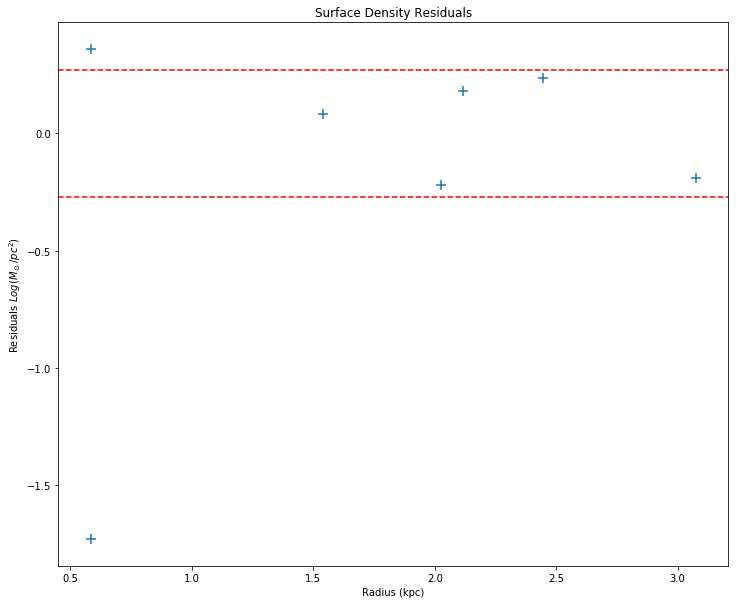

mad(Residual): 0.27082446105229163


In [184]:
old_bdor30 = np.where(old_r13bloop_cut['Field']=='30Dor')
old_blmc1 = np.where(old_r13bloop_cut['Field']=='LMC1')
old_blmc2 = np.where(old_r13bloop_cut['Field']=='LMC2')
old_blmc3 = np.where(old_r13bloop_cut['Field']=='LMC3')
old_blmc4 = np.where(old_r13bloop_cut['Field']=='LMC4')
old_blmc5 = np.where(old_r13bloop_cut['Field']=='LMC5')
old_blmc6 = np.where(old_r13bloop_cut['Field']=='LMC6')
old_blmc7 = np.where(old_r13bloop_cut['Field']=='LMC7')
old_blmc8 = np.where(old_r13bloop_cut['Field']=='LMC8')
old_blmc9 = np.where(old_r13bloop_cut['Field']=='LMC9')
old_blmc10 = np.where(old_r13bloop_cut['Field']=='LMC10')
old_blmc11 = np.where(old_r13bloop_cut['Field']=='LMC11')
old_blmc12 = np.where(old_r13bloop_cut['Field']=='LMC12')
old_blmc13 = np.where(old_r13bloop_cut['Field']=='LMC13')
old_blmc14 = np.where(old_r13bloop_cut['Field']=='LMC14')
old_blmc16 = np.where(old_r13bloop_cut['Field']=='LMC16')
old_blmc17 = np.where(old_r13bloop_cut['Field']=='LMC17')

old_fields = [old_bdor30,old_blmc1,old_blmc2,old_blmc3,old_blmc4,old_blmc5,old_blmc6,old_blmc7,
          old_blmc8,old_blmc9,old_blmc10,old_blmc11,old_blmc12,old_blmc13,old_blmc14,old_blmc16,
          old_blmc17]

old_radii = []
# angles = []
old_surfden = []
for i in range(len(old_fields)):
    old_radii.append(np.sqrt(np.median(LMCdisk_cart(old_r13bloop_cut['RA'][old_fields[i]],
                                                old_r13bloop_cut['DEC'][old_fields[i]])[0])**2+
                         np.median(LMCdisk_cart(old_r13bloop_cut['RA'][old_fields[i]],
                                                old_r13bloop_cut['DEC'][old_fields[i]])[1])**2))
    
    old_surfden.append((old_masses[i]/old_areas[i]))
    
old_good = np.where(np.isfinite(np.log(np.divide((np.asarray(old_surfden)),10**6)))==True)

model = (np.asarray(old_radii)[old_good]).T#np.array([old_radii]).T
model = sm.add_constant(model)
model_model = sm.RLM(np.log(np.divide((np.asarray(old_surfden)[old_good]),10**6)),model).fit()
model_predictions = model_model.predict(model)
model_residual = model_predictions - np.log(np.divide((np.asarray(old_surfden)[old_good]),10**6))
model_summary = model_model.summary()
print(model_summary)
print(np.asarray(model_model.params))
plt.figure(figsize=[12,10])
plt.scatter(np.asarray(old_radii)[old_good],model_residual,marker='+',label='Residuals',cmap='nipy_spectral',
            s=100)
plt.axhline(mad(model_residual),linestyle='--',c='r',label='MAD')
plt.axhline(-mad(model_residual),linestyle='--',c='r')
plt.title(r'Surface Density Residuals')
plt.xlabel(r'Radius (kpc)')
plt.ylabel(r'Residuals $Log(M_\odot/pc^2)$')
# plt.colorbar()
# plt.savefig('residexpmodel.pdf',bbox_inches='tight')
plt.show()
print('mad(Residual):',mad(model_residual))

In [182]:
old_masses

[16784660.06222746,
 1856913.417473018,
 2099115.1924836505,
 8722040.490983136,
 nan,
 (array([591, 592, 593, 594, 596, 600, 602, 603, 607, 614, 616, 617, 618,
         619, 620, 621, 626, 627, 629, 630, 631, 633, 635, 638, 640, 643,
         644, 645, 646, 647, 648, 651, 653, 654, 655, 659, 661, 662, 665,
         667, 671, 674, 675, 676, 677, 680, 684, 686, 691, 694, 696, 697,
         700, 701, 702, 705, 706, 707, 708, 718, 722, 729, 737, 748, 749,
         750, 755, 757, 758, 759, 761, 764, 771, 772, 780, 783, 785, 790,
         791, 792, 794, 795]),),
 26811584.803885024,
 18691693.01943112,
 33244696.638789583,
 182744866.5871218,
 8437914.50599603,
 42057851.73228802,
 nan,
 31713068.85258505,
 45797173.89661753,
 2633170.7450644504,
 16433169.386969225]

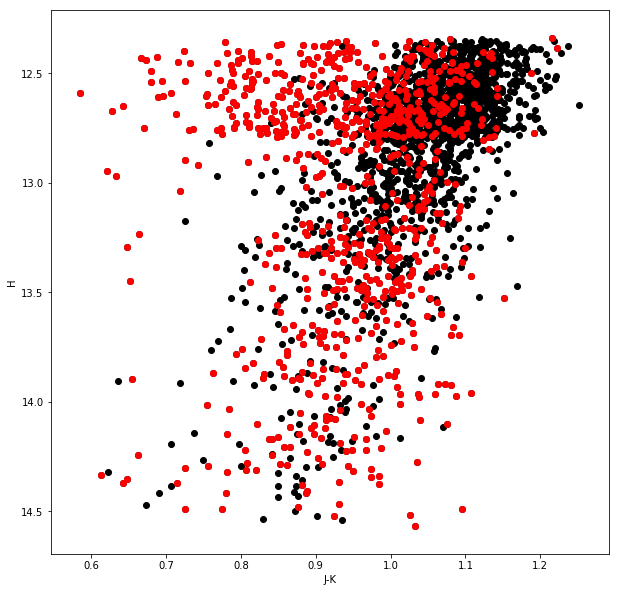

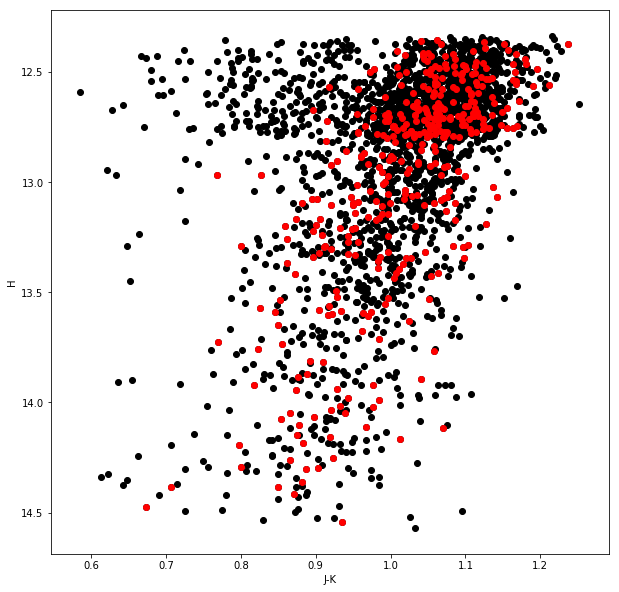

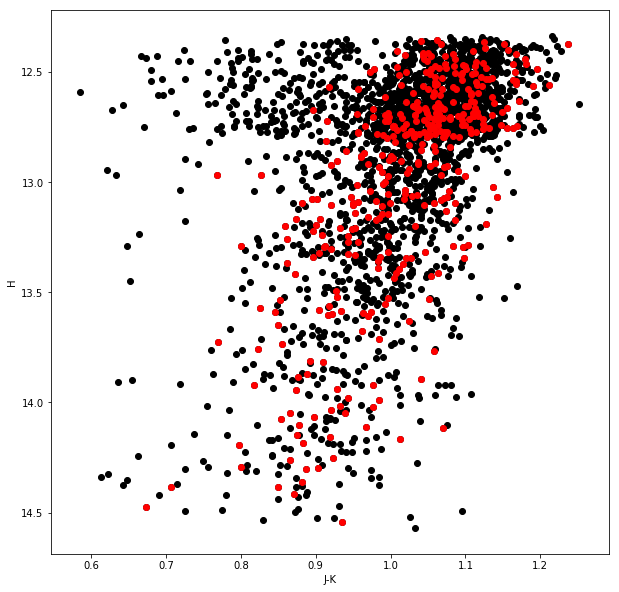

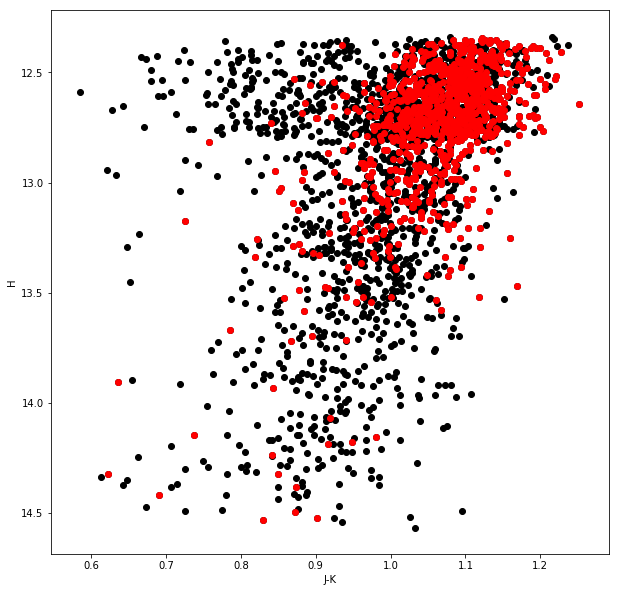